# AEVB Model Development

## 1. Version Log

This version: v1.3

Log: 

1. 2020/04/22: first baseline version created.
    - alpha: 0.01 does not work, can train with 0.001
2. 2020/04/24: 
    - ADAM
        - implemented ADAM
        - added functionality to output file status during training
        - added flexibility to start training based on user-specified parameters
    - profiling
3. 2020/04/25:
    - speed up
        - updated training function to take in grad as function for easier testing
4. 2020/04/28:
    - "total_loss"
        - corrected error in "total_loss" function though it didn't have any effect before as L has been set to 1
5. 2020/04/30:
    - finalized with each version and all workings documented and tidied up

In [103]:
Model_version = "v1.3"

## 2. Variable Dimensions

Data
- X: M by dx (100 by 784)
- y: M by L by dx (100 by 1 by 784)

for calculating total loss by batch
- q_mu: M by dz (100 by dz)
- q_s2: M by dz (100 by dz)
- q_a2: M by dz (100 by dz)

for calculating gradients by batch
- q_h1: M by dm (100 by dm)
- p_h2: M by L by dm (100 by 1 by dm)
- z: M by L by dz (100 by 1 by dz)
- eps: L by dz

## 3. Load Data

In [104]:
# load dataset
from keras.datasets import mnist
import matplotlib.pyplot as plt

(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


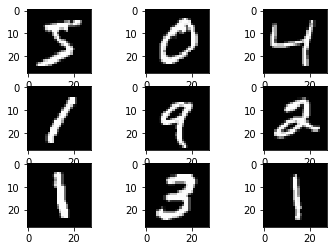

In [105]:
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

## 4. Baseline Codes

In [106]:
# load packages
import numpy as np
import datetime
import pytz
import pickle

### 4.1 Baseline Functions

These are baseline version codes (model v0 in final report). Note that due to changes during optimization, some of the functions are not compatible with later/ final version of the codes.

In [107]:
def get_Batch(M, trainX, trainy):
    """randomly sample a mini batch of size M from the training data"""
    
    N = trainX.shape[0]
    sample = np.random.choice(N,M)
    
    return trainX[sample], trainy[sample]

def sigmoid(x):
    """sigmoid function"""
    return 1/(1+np.exp(-x))

def sigmoid_gradient(x):
    """gradient of sigmoid function"""
    return x * (1-x)

def tanh(x):
    """tanh function"""
    return np.tanh(x)
    
def tanh_gradient(x):
    """gradient of tanh function"""
    return 1-np.power(x,2)

In [108]:
def init_random(dx, dm, dz, option = "xavier"):
    """
    parameter initialization
    xavier initialization for weights
    all zero for bias
    can be used to initialize all zero variables for ADAM by setting "option = zeros"
    """
    
    # weights initialization
    if option == "zeros":
        # only for variables in ADAM algorithm, not to be used for true model parameters
        q_W1 = np.zeros((dm, dx))
        p_W5 = np.zeros((dx, dm))
        q_W2 = np.zeros((dz, dm))
        q_W3 = np.zeros((dz, dm))
        p_W4 = np.zeros((dm, dz))
    elif option == "xavier":
        bound = np.sqrt(6)/ np.sqrt(dx + dm)
        q_W1 = np.random.uniform(-bound, bound, (dm, dx))
        p_W5 = np.random.uniform(-bound, bound, (dx, dm))
        bound = np.sqrt(6)/ np.sqrt(dm + dz)
        q_W2 = np.random.uniform(-bound, bound, (dz, dm))
        q_W3 = np.random.uniform(-bound, bound, (dz, dm))
        p_W4 = np.random.uniform(-bound, bound, (dm, dz))
    
    # bias initialization
    q_b1 = np.zeros((dm, 1))
    p_b5 = np.zeros((dx, 1))
    q_b2 = np.zeros((dz, 1))
    q_b3 = np.zeros((dz, 1))
    p_b4 = np.zeros((dm, 1))
    
    W = [q_W1, q_W2, q_W3, p_W4, p_W5]
    b = [q_b1, q_b2, q_b3, p_b4, p_b5]
    
    return W, b

In [109]:
def total_loss(X, y, q_a2, q_mu, q_s2):
    """target total loss function - to minimize"""
    
    M = X.shape[0]
    L = y.shape[1]
    
    loss = 0
    for iD in range(M):
        for iL in range(L):
            # reconstruction loss for each sample of latent variable
            loss = loss - np.sum(X[iD,] * np.log(y[iD,iL,]) + (1-X[iD,]) * np.log(1-y[iD,iL,])) / L
        
        # KL divergence/ regularization
        loss = loss + np.sum(np.power(q_mu[iD,],2) + q_s2[iD,] - q_a2[iD,] - 1)/2
    
    return loss / M

In [110]:
def encoder_forward(X, W, b):
    """
    encoder forward propagation for each data point
    X: dx by 1
    """
    
    q_W1, q_W2, q_W3, d,d = W
    q_b1, q_b2, q_b3, d,d = b
    
    q_a1 = q_W1 @ X + q_b1
    q_h1 = tanh(q_a1)
    q_mu = q_W2 @ q_h1 + q_b2
    q_a2 = q_W3 @ q_h1 + q_b3
    q_s2 = np.exp(q_a2)
    
    return q_h1.T, q_a2.T, q_mu.T, q_s2.T

In [111]:
def sample_z(q_mu, q_s2, eps):
    """sample z"""
    return q_mu + np.sqrt(q_s2) * eps

In [112]:
def decoder_forward(W, b, z):
    """
    decoder forward propagation for each data point and each sample latent variable
    z: dz by 1
    """
    
    d,d,d, p_W4, p_W5 = W
    d,d,d, p_b4, p_b5 = b
    
    p_a3 = p_W4 @ z + p_b4
    p_h2 = tanh(p_a3)
            
    p_a4 = p_W5 @ p_h2 + p_b5
    y = sigmoid(p_a4)
    
    return y.T, p_h2.T

In [113]:
def grad(X, y, W, b, H, Lt):
    """"
    batch gradient
    inputs:
        X: M by dx
        y: M by L by dx
        W: weights
        b: bias
        H: q_h1 (M by dm), p_h2 (M by L by dm)
        Lt: eps (L by dz), z (M by L by dz), q_s2 (M by dz), q_mu (M by dz)
    """
    q_W1, q_W2, q_W3, p_W4, p_W5 = W
    q_b1, q_b2, q_b3, p_b4, p_b5 = b
    q_h1, p_h2 = H
    q_mu, q_s2, z, eps = Lt
    
    M = X.shape[0]
    L = y.shape[1]
    
    # initialize gradient variables
    
    # L: loss; R: regularization; J: total target
    dL_dW1 = dJ_dW1 = dR_dW1 = np.zeros_like(q_W1)
    dL_db1 = dJ_db1 = dR_db1 = np.zeros_like(q_b1)
    dL_dW2 = dJ_dW2 = dR_dW2 = np.zeros_like(q_W2)
    dL_db2 = dJ_db2 = dR_db2 = np.zeros_like(q_b2)
    dL_dW3 = dJ_dW3 = dR_dW3 = np.zeros_like(q_W3)
    dL_db3 = dJ_db3 = dR_db3 = np.zeros_like(q_b3)
    dL_dW4 = dJ_dW4 = np.zeros_like(p_W4)
    dL_db4 = dJ_db4 = np.zeros_like(p_b4)    
    dL_dW5 = dJ_dW5 = np.zeros_like(p_W5)
    dL_db5 = dJ_db5 = np.zeros_like(p_b5)
    
    for iD in range(M):
        for iL in range(L):
            # back propagation for loss

            #L_d4 = (np.divide(y[iD,iL,]-X[iD,], y[iD,iL,] * (1-y[iD,iL,])) * sigmoid_gradient(y[iD,iL,])).reshape(-1,1)
            
            # simplied L_d4
            L_d4 = (y[iD,iL,]-X[iD,]).reshape(-1,1)
            dL_dW5 = dL_dW5 + L_d4 @ p_h2[iD,iL,].reshape(1,-1)
            dL_db5 = dL_db5 + L_d4
            
            L_d3 = p_W5.T @ L_d4 * tanh_gradient(p_h2[iD,iL,]).reshape(-1,1)
            dL_dW4 = dL_dW4 + L_d3 @ z[iD,iL,].reshape(1,-1)
            dL_db4 = dL_db4 + L_d3
            
            L_d22 = p_W4.T @ L_d3 * eps[iL,].reshape(-1,1) * np.sqrt(q_s2[iD,]).reshape(-1,1) / 2
            dL_dW3 = dL_dW3 + L_d22 @ q_h1[iD,].reshape(1,-1)
            dL_db3 = dL_db3 + L_d22
            
            L_d21 = p_W4.T @ L_d3
            dL_dW2 = dL_dW2 + L_d21 @ q_h1[iD,].reshape(1,-1)
            dL_db2 = dL_db2 + L_d21
            
            L_d1 = (q_W2.T @ L_d21 + q_W3.T @ L_d22) * tanh_gradient(q_h1[iD,]).reshape(-1,1)
            dL_dW1 = dL_dW1 + L_d1 @ X[iD,].reshape(1,-1)
            dL_db1 = dL_db1 + L_d1
        
        # back propagation for regularization
        R_d22 = ((q_s2[iD,]-1)/2).reshape(-1,1)
        dR_dW3 = dR_dW3 + R_d22 @ q_h1[iD,].reshape(1,-1)
        dR_db3 = dR_db3 + R_d22

        R_d21 = q_mu[iD,].reshape(-1,1)
        dR_dW2 = dR_dW2 + R_d21 @ q_h1[iD,].reshape(1,-1)
        dR_db2 = dR_db2 + R_d21

        R_d1 = (q_W3.T @ R_d22 + q_W2.T @ R_d21) * tanh_gradient(q_h1[iD,]).reshape(-1,1)
        dR_dW1 = dR_dW1 + R_d1 @ X[iD,].reshape(1,-1)
        dR_db1 = dR_db1 + R_d1
    
    dJ_dW1 = dL_dW1 / L / M + dR_dW1 / M
    dJ_db1 = dL_db1 / L / M + dR_db1 / M
    dJ_dW2 = dL_dW2 / L / M + dR_dW2 / M
    dJ_db2 = dL_db2 / L / M + dR_db2 / M    
    dJ_dW3 = dL_dW3 / L / M + dR_dW3 / M
    dJ_db3 = dL_db3 / L / M + dR_db3 / M
    dJ_dW4 = dL_dW4 / L / M
    dJ_db4 = dL_db4 / L / M 
    dJ_dW5 = dL_dW5 / L / M
    dJ_db5 = dL_db5 / L / M
    
    dW = [dJ_dW1, dJ_dW2, dJ_dW3, dJ_dW4, dJ_dW5]
    db = [dJ_db1, dJ_db2, dJ_db3, dJ_db4, dJ_db5]
    
    return dW, db

In [114]:
def batch_forward(Spec, X, W, b, eps):
    """forward propagation for one batch"""
    d, M, L, d, d, dm, dz, d, d = Spec
    
    # initialize variables for calculating gradients/ loss by batch
    q_h1 = np.zeros((M, dm))
    q_mu = np.zeros((M, dz))
    q_s2 = np.zeros((M, dz))
    q_a2 = np.zeros((M, dz))
    p_h2 = np.zeros((M, L, dm))
    z = np.zeros((M, L, dz))
    y = np.zeros((M, L, dx))
    
    for iD in range(M):
        q_h1[iD,], q_a2[iD,], q_mu[iD,], q_s2[iD,] = encoder_forward(X[iD,].reshape(-1,1), W, b)

        for iL in range(L):
            z[iD,iL,] = sample_z(q_mu[iD,], q_s2[iD,], eps[iL,])
            y[iD,iL,], p_h2[iD,iL,] = decoder_forward(W, b, z[iD,iL,].reshape(-1,1))
    
    H = [q_h1, p_h2]
    Lt = [q_mu, q_s2, z, eps]
    loss = total_loss(X, y, q_a2, q_mu, q_s2)
    return y, H, Lt, loss

In [115]:
def para_update(W, b, dW, db, alpha):
    """update weights and bias for gradient descent"""
    
    assert len(W) == len(b) == len(dW) == len(db)
    n = len(W)
    
    for i in range(n):
        W[i] = W[i] - alpha * dW[i]
        b[i] = b[i] - alpha * db[i]
    
    return W, b

In [116]:
def plot_samples(Spec, n, W, b):
    """plot n number of random sampled figures as well as the model-reconstructed versions"""
    
    d, d, L, std_const, dx, dm, dz, d, d = Spec
    Spec[1] = n
    
    batchX, batchy = get_Batch(n, trainX, trainy)
    Xdim1, Xdim2 = batchX[0].shape[0], batchX[0].shape[1]
    assert dx == Xdim1 * Xdim2
    X = batchX.reshape(n, dx) / std_const
    eps = np.zeros((L, dz))
    
    y, d,d,d = batch_forward(Spec, X, W, b, eps)
    
    for i in range(n):
        # define subplot
        plt.subplot(330 + 1 + i)
        # plot raw pixel data
        plt.imshow(batchX[i], cmap=plt.get_cmap('gray'))
    # show the figure
    plt.show()
    
    for i in range(n):
        # define subplot
        plt.subplot(330 + 1 + i)
        # plot raw pixel data
        plt.imshow(y[i,L-1,].reshape(Xdim1, Xdim2) * std_const, cmap=plt.get_cmap('gray'))
    # show the figure
    plt.show()

In [117]:
def train(trainX, trainy, Spec, grad, doc = ""):
    """train model with vanila gradient descent"""
    nBatch, M, L, std_const, dx, dm, dz, alpha, nP = Spec
    status_file = get_filename("status")
    para_file = get_filename("parameter")
    
    # weights and bias initialization
    W, b = init_random(dx, dm, dz)

    # loss
    loss = np.zeros(nBatch)
    
    # create status file
    update_status(status_file, "x", "Training starts: " + get_timestamp() + "\n")
    
    for iB in range(nBatch):
        # sample a random batch
        batchX, batchy = get_Batch(M, trainX, trainy)
        X = batchX.reshape(M, dx) / std_const

        # sample random noise for latent variable, assuming each batch uses the same random noise for now
        eps = np.random.randn(L, dz)

        y, H, Lt, loss[iB] = batch_forward(Spec, X, W, b, eps)

        dW, db = grad(X, y, W, b, H, Lt)
        W, b = para_update(W, b, dW, db, alpha)
        
        if (iB+1) % nP == 0:
            # append status file
            update_status(status_file, "a", "Batch " + str(iB+1) + " : " + get_timestamp() + "\n")
    
    # save parameter to file
    save_para(para_file, doc = doc, Spec = Spec, W = W, b = b, loss = loss)
    
    return Spec, W, b, loss

### 4.2 Baseline Training

Codes used to call baseline version functions for model training. Again due to later changes during optimization, some of these codes might not be compatible to later/ final version of the codes.

In [118]:
# set parameters
nBatch = 60000 # number of mini-batch to train
M = 100 # batch size
L = 1 # sample size
std_const = 255 # to standardize data

Xdim1, Xdim2 = trainX[0].shape[0], trainX[0].shape[1]
dx = Xdim1 * Xdim2 # dimension of the input
dm = 500 # dimension of the hidden layer
dz = 3 # dimension of latent variable

alpha = 0.005 # learning rate

nP = 1000 # print out status every nP batches

Spec = [nBatch, M, L, std_const, dx, dm, dz, alpha, nP]

Example codes to train using Model v0

In [123]:
# Spec, W, b, loss = train(trainX, trainy, Spec, grad)

### 4.3 Helper Functions

These are functions used during model developments but not used in anyb way in the final version of the codes.

In [124]:
def save_para(filename, **kwargs):
    """save weights and bias parameters"""
    file = open(filename, 'wb')
    pickle.dump(kwargs, file)
    file.close()

def get_para(filename):
    """read parameters from file"""
    file = open(filename, 'rb')
    dict = pickle.load(file)
    return dict

def get_filename(suffix="", format = "%Y_%m_%d_%H_%M_%S", ext = ".txt"):
    """create file name"""
    if suffix != "":
        suffix = "_" + suffix
    res = get_timestamp(format = format) + "_Model_" + Model_version + suffix + ext
    return res

def update_status(filename, mode, msg):
    """for training status update"""
    with open(filename, mode) as f:
        f.write(msg)
        
def get_timestamp(timezone = "America/New_York", format = "%Y/%m/%d %H:%M:%S"):
    """formatted date time in local timezone"""
    now = datetime.datetime.now().astimezone(pytz.timezone("America/New_York"))
    return now.strftime(format)

Example codes to save model parameters after model run.

In [125]:
#doc = """Second run using ADAM."""

#filename = get_filename("parameter")
#save_para(filename, doc = doc, Spec = Spec, W = W, b = b, loss = loss)

Example codes to read back parameters.

In [126]:
# filename = "2020_04_24_15_25_12_Model_v1.1_parameter.txt"
# para = get_para(filename)
# doc = para['doc']
# W = para['W']
# b = para['b']

Example codes ro continue training using existing parameters (only applies to model version after v1)

In [127]:
# Spec, W, b, loss = train_ADAM(trainX, trainy, Spec, grad, W = W, b = b, doc = "continue run from 2020_04_24_15_25_12 parameter")

Example codes to plot a few samples

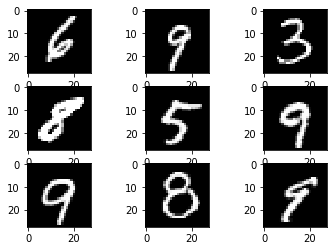

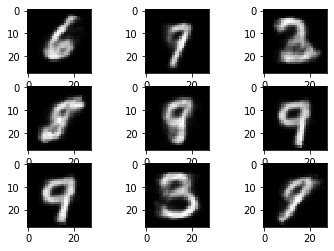

In [75]:
# plot_samples(Spec, 9, W, b)

Example codes to plot loss returned by the model.

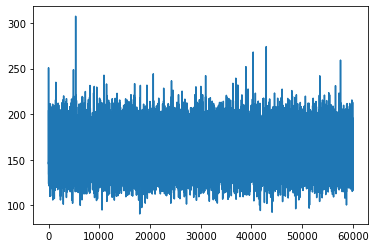

In [73]:
# plt.plot(loss);

## 5. Optimization -- Algorithm

These are codes for the first implementation of ADAM algorithm (Model v1 in the final report).

In [128]:
def train_ADAM(trainX, trainy, Spec, batch_forward, grad, W = "", b = "", doc = ""):
    """train model with ADAM"""
    
    nBatch, M, L, std_const, dx, dm, dz, alpha, nP = Spec
    
    if doc != "":
        status_file = get_filename("status")
        para_file = get_filename("parameter")
        update_status(status_file, "x", "Training starts: " + get_timestamp() + "\n")
    
    # parameters for ADAM algorithm
    beta1 = 0.9
    beta2 = 0.999
    eps_stable = 1e-8
    
    # initiate parameters for ADAM
    # need to use separate lines of codes otherwise they share the same reference
    v_dW, v_db = init_random(dx, dm, dz, option = "zeros")
    s_dW, s_db = init_random(dx, dm, dz, option = "zeros")
    vc_dW, vc_db = init_random(dx, dm, dz, option = "zeros")
    sc_dW, sc_db = init_random(dx, dm, dz, option = "zeros")
    num_para = len(v_dW)
    
    # weights and bias initialization
    if len(W) == len(b) == 0:
        W, b = init_random(dx, dm, dz)

    # loss
    loss = np.zeros(nBatch)
    
    for iB in range(nBatch):
        # sample a random batch
        batchX, batchy = get_Batch(M, trainX, trainy)
        X = batchX.reshape(M, dx) / std_const

        # sample random noise for latent variable, assuming each batch uses the same random noise for now
        eps = np.random.randn(L, dz)

        y, H, Lt, loss[iB] = batch_forward(Spec, X, W, b, eps)
        dW, db = grad(X, y, W, b, H, Lt)
        
        # ADAM
        for i in range(num_para):
            v_dW[i] = beta1*v_dW[i] + (1-beta1)*dW[i]
            v_db[i] = beta1*v_db[i] + (1-beta1)*db[i]
            s_dW[i] = beta2*s_dW[i] + (1-beta2)*np.power(dW[i],2)
            s_db[i] = beta2*s_db[i] + (1-beta2)*np.power(db[i],2)
        
            vc_dW[i] = v_dW[i]/(1-beta1**(iB+1))
            vc_db[i] = v_db[i]/(1-beta1**(iB+1))
            sc_dW[i] = s_dW[i]/(1-beta2**(iB+1))
            sc_db[i] = s_db[i]/(1-beta2**(iB+1))
        
            dW[i] = vc_dW[i] / (np.sqrt(sc_dW[i]) + eps_stable)
            db[i] = vc_db[i] / (np.sqrt(sc_db[i]) + eps_stable)
        
        W, b = para_update(W, b, dW, db, alpha)
        
        if doc != "":
            if (iB+1) % nP == 0:
                # append status file
                update_status(status_file, "a", "Batch " + str(iB+1) + " : " + get_timestamp() + "\n")
    
    # save parameter to file
    if doc != "":
        save_para(para_file, doc = doc, Spec = Spec, W = W, b = b, loss = loss)

    return Spec, W, b, loss

## 6. Profiling

We did profiling on Model v1, i.e., baseline codes with ADAM algorithm.

In [129]:
import pstats

Example codes to create profiling file name, change batch size to 100 and proceed with profiling.

In [37]:
# profile_filename = get_filename("profiling", ext = ".prof")
# Spec = [100, M, L, std_const, dx, dm, dz, alpha, 10]

In [38]:
# %prun -q -D $profile_filename train_ADAM(trainX, trainy, Spec, grad_nb, doc = "Profiling grad_nb")

 
*** Profile stats marshalled to file '2020_04_25_15_58_54_Model_v1.2_profiling.prof'. 


Example codes to print all the statistics (random order)

In [130]:
# p = pstats.Stats(profile_filename)
# p.print_stats()
# pass

Example codes to get statistics sorted by run time. Note that we can specify the specific function to look at by changing inputs in "print_stats".

In [131]:
# p.sort_stats('time', 'cumulative').print_stats(5)
# pass

In [42]:
# p.sort_stats('time', 'cumulative').print_stats('grad')
# pass

Sat Apr 25 19:59:39 2020    2020_04_25_15_58_54_Model_v1.2_profiling.prof

         276418 function calls (274318 primitive calls) in 43.572 seconds

   Ordered by: internal time, cumulative time
   List reduced from 77 to 1 due to restriction <'grad'>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  200/100   36.859    0.184   36.964    0.370 <ipython-input-31-c1ccc69c24a4>:1(grad_nb)




Example codes for statistics sorted by number of calls.

In [132]:
# p.sort_stats('ncalls').print_stats(5)
# pass

## 7. Optimization

In [133]:
import numba
from numba import jit, njit

In [134]:
from numba.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

### 7.1 Minimalist

This version is to try to use minimal efforts to speed up (denoted as model v1.5 because it is in between model v1 and v2 referenced by the final report). The goal here is to try make minimal changes to the codes and use numba jit.

Naming convension:
    - functions which I enviziege will only have one version of numba implementation are named with suffix "_nb".
    - functions which I realize I'll try other versions of numba implementations (in order to use nopython) are named with suffix "_nb1".
    
Here we try to use *nopython* as much as possible. However, because of the use of heterogeneous lists in the codes for passing parameters, a number of functions can only be jitted under object mode.

#### 7.1.1 Model v1.5 Codes

In [135]:
sigmoid_nb = jit(sigmoid, nopython=True, cache=True)
sigmoid_gradient_nb = jit(sigmoid_gradient, nopython=True, cache=True)
tanh_nb = jit(tanh, nopython=True, cache=True)
tanh_gradient_nb = jit(tanh_gradient, nopython=True, cache=True)
total_loss_nb = jit(total_loss, nopython=True, cache=True)
sample_z_nb = jit(sample_z, nopython=True, cache=True)

In [136]:
@njit(cache=True)
def encoder_forward_nb1(X, W, b):
    """
    encoder forward propagation for each data point
    X: dx by 1
    """
    
    q_W1, q_W2, q_W3, d,d = W
    q_b1, q_b2, q_b3, d,d = b
    
    q_a1 = q_W1 @ X + q_b1
    q_h1 = tanh_nb(q_a1)
    q_mu = q_W2 @ q_h1 + q_b2
    q_a2 = q_W3 @ q_h1 + q_b3
    q_s2 = np.exp(q_a2)
    
    return q_h1.T, q_a2.T, q_mu.T, q_s2.T

In [137]:
@njit(cache=True)
def decoder_forward_nb1(W, b, z):
    """
    decoder forward propagation for each data point and each sample latent variable
    z: dz by 1
    """
    
    d,d,d, p_W4, p_W5 = W
    d,d,d, p_b4, p_b5 = b
    
    p_a3 = p_W4 @ z + p_b4
    p_h2 = tanh_nb(p_a3)
            
    p_a4 = p_W5 @ p_h2 + p_b5
    y = sigmoid_nb(p_a4)
    
    return y.T, p_h2.T

In [138]:
@jit(cache=True)
def batch_forward_nb1(Spec, X, W, b, eps):
    """forward propagation for one batch"""
    d, M, L, d, d, dm, dz, d, d = Spec
    
    # initialize variables for calculating gradients/ loss by batch
    q_h1 = np.zeros((M, dm))
    q_mu = np.zeros((M, dz))
    q_s2 = np.zeros((M, dz))
    q_a2 = np.zeros((M, dz))
    p_h2 = np.zeros((M, L, dm))
    z = np.zeros((M, L, dz))
    y = np.zeros((M, L, dx))
    
    for iD in range(M):
        q_h1[iD,], q_a2[iD,], q_mu[iD,], q_s2[iD,] = encoder_forward_nb1(X[iD,].reshape(-1,1), W, b)

        for iL in range(L):
            z[iD,iL,] = sample_z_nb(q_mu[iD,], q_s2[iD,], eps[iL,])
            y[iD,iL,], p_h2[iD,iL,] = decoder_forward_nb1(W, b, z[iD,iL,].reshape(-1,1))
    
    H = [q_h1, p_h2]
    Lt = [q_mu, q_s2, z, eps]
    loss = total_loss_nb(X, y, q_a2, q_mu, q_s2)
    return (y, H, Lt, loss)

In [139]:
@jit(cache=True)
def grad_nb1(X, y, W, b, H, Lt):
    """"
    batch gradient
    inputs:
        X: M by dx
        y: M by L by dx
        W: weights
        b: bias
        H: q_h1 (M by dm), p_h2 (M by L by dm)
        Lt: eps (L by dz), z (M by L by dz), q_s2 (M by dz), q_mu (M by dz)
    """
    q_W1, q_W2, q_W3, p_W4, p_W5 = W
    q_b1, q_b2, q_b3, p_b4, p_b5 = b
    q_h1, p_h2 = H
    q_mu, q_s2, z, eps = Lt
    
    M = X.shape[0]
    L = y.shape[1]
    
    # initialize gradient variables
    
    # L: loss; R: regularization; J: total target
    dL_dW1 = dJ_dW1 = dR_dW1 = np.zeros_like(q_W1)
    dL_db1 = dJ_db1 = dR_db1 = np.zeros_like(q_b1)
    dL_dW2 = dJ_dW2 = dR_dW2 = np.zeros_like(q_W2)
    dL_db2 = dJ_db2 = dR_db2 = np.zeros_like(q_b2)
    dL_dW3 = dJ_dW3 = dR_dW3 = np.zeros_like(q_W3)
    dL_db3 = dJ_db3 = dR_db3 = np.zeros_like(q_b3)
    dL_dW4 = dJ_dW4 = np.zeros_like(p_W4)
    dL_db4 = dJ_db4 = np.zeros_like(p_b4)    
    dL_dW5 = dJ_dW5 = np.zeros_like(p_W5)
    dL_db5 = dJ_db5 = np.zeros_like(p_b5)
    
    for iD in range(M):
        for iL in range(L):
            # back propagation for loss

            #L_d4 = (np.divide(y[iD,iL,]-X[iD,], y[iD,iL,] * (1-y[iD,iL,])) * sigmoid_gradient(y[iD,iL,])).reshape(-1,1)
            
            # simplied L_d4
            L_d4 = (y[iD,iL,]-X[iD,]).reshape(-1,1)
            dL_dW5 = dL_dW5 + L_d4 @ p_h2[iD,iL,].reshape(1,-1)
            dL_db5 = dL_db5 + L_d4
            
            L_d3 = p_W5.T @ L_d4 * tanh_gradient_nb(p_h2[iD,iL,]).reshape(-1,1)
            dL_dW4 = dL_dW4 + L_d3 @ z[iD,iL,].reshape(1,-1)
            dL_db4 = dL_db4 + L_d3
            
            L_d22 = p_W4.T @ L_d3 * eps[iL,].reshape(-1,1) * np.sqrt(q_s2[iD,]).reshape(-1,1) / 2
            dL_dW3 = dL_dW3 + L_d22 @ q_h1[iD,].reshape(1,-1)
            dL_db3 = dL_db3 + L_d22
            
            L_d21 = p_W4.T @ L_d3
            dL_dW2 = dL_dW2 + L_d21 @ q_h1[iD,].reshape(1,-1)
            dL_db2 = dL_db2 + L_d21
            
            L_d1 = (q_W2.T @ L_d21 + q_W3.T @ L_d22) * tanh_gradient_nb(q_h1[iD,]).reshape(-1,1)
            dL_dW1 = dL_dW1 + L_d1 @ X[iD,].reshape(1,-1)
            dL_db1 = dL_db1 + L_d1
        
        # back propagation for regularization
        R_d22 = ((q_s2[iD,]-1)/2).reshape(-1,1)
        dR_dW3 = dR_dW3 + R_d22 @ q_h1[iD,].reshape(1,-1)
        dR_db3 = dR_db3 + R_d22

        R_d21 = q_mu[iD,].reshape(-1,1)
        dR_dW2 = dR_dW2 + R_d21 @ q_h1[iD,].reshape(1,-1)
        dR_db2 = dR_db2 + R_d21

        R_d1 = (q_W3.T @ R_d22 + q_W2.T @ R_d21) * tanh_gradient_nb(q_h1[iD,]).reshape(-1,1)
        dR_dW1 = dR_dW1 + R_d1 @ X[iD,].reshape(1,-1)
        dR_db1 = dR_db1 + R_d1
    
    dJ_dW1 = dL_dW1 / L / M + dR_dW1 / M
    dJ_db1 = dL_db1 / L / M + dR_db1 / M
    dJ_dW2 = dL_dW2 / L / M + dR_dW2 / M
    dJ_db2 = dL_db2 / L / M + dR_db2 / M    
    dJ_dW3 = dL_dW3 / L / M + dR_dW3 / M
    dJ_db3 = dL_db3 / L / M + dR_db3 / M
    dJ_dW4 = dL_dW4 / L / M
    dJ_db4 = dL_db4 / L / M 
    dJ_dW5 = dL_dW5 / L / M
    dJ_db5 = dL_db5 / L / M
    
    dW = [dJ_dW1, dJ_dW2, dJ_dW3, dJ_dW4, dJ_dW5]
    db = [dJ_db1, dJ_db2, dJ_db3, dJ_db4, dJ_db5]
    
    return dW, db

In [140]:
@jit
def train_ADAM_nb1(trainX, trainy, Spec, batch_forward, grad, W = "", b = ""):
    """train model with ADAM"""
    
    nBatch, M, L, std_const, dx, dm, dz, alpha, nP = Spec
    
    # parameters for ADAM algorithm
    beta1 = 0.9
    beta2 = 0.999
    eps_stable = 1e-8
    
    # initiate parameters for ADAM
    # need to use separate lines of codes otherwise they share the same reference
    v_dW, v_db = init_random(dx, dm, dz, option = "zeros")
    s_dW, s_db = init_random(dx, dm, dz, option = "zeros")
    vc_dW, vc_db = init_random(dx, dm, dz, option = "zeros")
    sc_dW, sc_db = init_random(dx, dm, dz, option = "zeros")
    num_para = len(v_dW)
    
    # weights and bias initialization
    if len(W) == len(b) == 0:
        W, b = init_random(dx, dm, dz)

    # loss
    loss = np.zeros(nBatch)
    
    for iB in range(nBatch):
        # sample a random batch
        batchX, batchy = get_Batch(M, trainX, trainy)
        X = batchX.reshape(M, dx) / std_const

        # sample random noise for latent variable, assuming each batch uses the same random noise for now
        eps = np.random.randn(L, dz)

        y, H, Lt, loss[iB] = batch_forward(Spec, X, W, b, eps)
        dW, db = grad(X, y, W, b, H, Lt)
        
        # ADAM
        for i in range(num_para):
            v_dW[i] = beta1*v_dW[i] + (1-beta1)*dW[i]
            v_db[i] = beta1*v_db[i] + (1-beta1)*db[i]
            s_dW[i] = beta2*s_dW[i] + (1-beta2)*np.power(dW[i],2)
            s_db[i] = beta2*s_db[i] + (1-beta2)*np.power(db[i],2)
        
            vc_dW[i] = v_dW[i]/(1-beta1**(iB+1))
            vc_db[i] = v_db[i]/(1-beta1**(iB+1))
            sc_dW[i] = s_dW[i]/(1-beta2**(iB+1))
            sc_db[i] = s_db[i]/(1-beta2**(iB+1))
        
            dW[i] = vc_dW[i] / (np.sqrt(sc_dW[i]) + eps_stable)
            db[i] = vc_db[i] / (np.sqrt(sc_db[i]) + eps_stable)
        
        W, b = para_update(W, b, dW, db, alpha)

    return Spec, W, b, loss

#### 7.1.2 Model v1.5 Profiling

The following are codes used for profiling. Currently comma out for documentation

In [141]:
# profile_filename = get_filename("profiling_v1", ext = ".prof")
# Spec = [100, M, L, std_const, dx, dm, dz, alpha, 10]

In [143]:
#%prun -q -D $profile_filename train_ADAM_nb1(trainX, \
#                                         trainy, Spec, batch_forward_nb1, grad_nb1, doc = "Optimization v1")

In [100]:
# p = pstats.Stats(profile_filename)
# p.sort_stats('time', 'cumulative').print_stats(5)
# pass

Wed Apr 29 15:09:32 2020    2020_04_29_11_08_34_Model_v1.2_profiling_v1.prof

         8904696 function calls (8251444 primitive calls) in 57.791 seconds

   Ordered by: internal time, cumulative time
   List reduced from 1533 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  200/100   31.275    0.156   31.372    0.314 <ipython-input-65-13a3e80c32ab>:1(grad_nb1)
3309/3308    4.970    0.002    4.973    0.002 /opt/conda/lib/python3.6/site-packages/llvmlite/binding/ffi.py:112(__call__)
      2/1    2.817    1.409   50.895   50.895 <ipython-input-17-fa9db8bd10df>:1(train_ADAM)
  200/100    1.861    0.009    2.616    0.026 <ipython-input-61-421a667b6d90>:1(batch_forward_nb1)
  1861957    1.079    0.000    1.093    0.000 {built-in method builtins.isinstance}




### 7.2 Vectorization

In this version (Model v2 in the final report), we remove at least the inner loop through vectorization. We first tried to remove the inner loop in the Model v2, i.e., loop for latent variable samples. But soon we realized that since most of the time we only sample $1$ latent variable, removing this loop does not give us much speed up. Therefore we did a second version of vectorization (refer to *grad_vec2*) by removing the loop on sample data and keeping the loop for latent variable sampling. We decided to still keep one layer of looping to ensure calculations do not involve 3-D arrays so as to fully utilize numba later. And because we expect most of the time users will be using $L=1$, keeping the outer loop will not much affect code performance.

Note the following:

1. part of this version uses the functions already jitted in Model v3, but the main functions (e.g., *batch_forward* and *grad*) are not jitted.
2. somehow jit does not work on *grad_vec* even for object mode with error message *"can't unbox heterogeneous list: array(float64, 2d, C) != array(float64, 3d, C)".*

#### 7.2.1 Model v2 Codes

In [144]:
def encoder_forward_vec(X, W, b):
    """
    encoder forward propagation - vectorized version
    X: M by dx
    """
    
    q_W1, q_W2, q_W3, d,d = W
    q_b1, q_b2, q_b3, d,d = b
    
    q_a1 = q_W1 @ X.T + q_b1 # dm by M
    q_h1 = tanh_nb(q_a1) # dm by M
    q_mu = q_W2 @ q_h1 + q_b2 # dz by M
    q_a2 = q_W3 @ q_h1 + q_b3 # dz by M
    q_s2 = np.exp(q_a2) # dz by M
    
    return q_h1.T, q_a2.T, q_mu.T, q_s2.T

In [145]:
def sample_z_vec(q_mu, q_s2, eps):
    """sample latent variable z - vectorized version"""
    
    M, dz = q_mu.shape 

    return q_mu.reshape(M,1,dz) + np.sqrt(q_s2).reshape(M,1,dz) * eps

In [146]:
def decoder_forward_vec(W, b, z):
    """
    decoder forward propagation - vectorized version
    z: M by L by dz
    """
    
    d,d,d, p_W4, p_W5 = W
    d,d,d, p_b4, p_b5 = b
    
    p_a3 = z @ p_W4.T + p_b4.T # M by L by dm
    p_h2 = tanh_nb(p_a3) # M by L by dm
            
    p_a4 = p_h2 @ p_W5.T + p_b5.T # M by L by dx
    y = sigmoid_nb(p_a4) # M by L by dx
    
    return y, p_h2

In [147]:
def batch_forward_vec(Spec, X, W, b, eps):
    """forward propagation for one batch - vectorized version"""
    d, M, L, d, d, dm, dz, d, d = Spec
    
    # initialize variables for calculating gradients/ loss by batch
    p_h2 = np.zeros((M, L, dm))
    z = np.zeros((M, L, dz))
    y = np.zeros((M, L, dx))
    
    q_h1, q_a2, q_mu, q_s2 = encoder_forward_vec(X, W, b)
    z = sample_z_vec(q_mu, q_s2, eps)
    y, p_h2 = decoder_forward_vec(W, b, z)
    
    H = [q_h1, p_h2]
    Lt = [q_mu, q_s2, z, eps]
    loss = total_loss_vec(X, y, q_a2, q_mu, q_s2)
    
    return (y, H, Lt, loss)

In [148]:
def grad_vec(X, y, W, b, H, Lt):
    """"
    batch gradient
    inputs:
        X: M by dx
        y: M by L by dx
        W: weights
        b: bias
        H: q_h1 (M by dm), p_h2 (M by L by dm)
        Lt: eps (L by dz), z (M by L by dz), q_s2 (M by dz), q_mu (M by dz)
    """
    q_W1, q_W2, q_W3, p_W4, p_W5 = W
    q_b1, q_b2, q_b3, p_b4, p_b5 = b
    q_h1, p_h2 = H
    q_mu, q_s2, z, eps = Lt
    
    M = X.shape[0]
    L = y.shape[1]
    
    # initialize gradient variables
    
    # L: loss; R: regularization; J: total target
    dL_dW1 = dJ_dW1 = dR_dW1 = np.zeros_like(q_W1)
    dL_db1 = dJ_db1 = dR_db1 = np.zeros_like(q_b1)
    dL_dW2 = dJ_dW2 = dR_dW2 = np.zeros_like(q_W2)
    dL_db2 = dJ_db2 = dR_db2 = np.zeros_like(q_b2)
    dL_dW3 = dJ_dW3 = dR_dW3 = np.zeros_like(q_W3)
    dL_db3 = dJ_db3 = dR_db3 = np.zeros_like(q_b3)
    dL_dW4 = dJ_dW4 = np.zeros_like(p_W4)
    dL_db4 = dJ_db4 = np.zeros_like(p_b4)    
    dL_dW5 = dJ_dW5 = np.zeros_like(p_W5)
    dL_db5 = dJ_db5 = np.zeros_like(p_b5)
    
    for iD in range(M):
        
        # back propagation for loss
        L_d4 = y[iD,] - X[iD,].reshape(1,-1) # L by dx
        dL_dW5 = dL_dW5 + L_d4.T @ p_h2[iD,] # dx by dm
        dL_db5 = dL_db5 + np.sum(L_d4, axis = 0).reshape(-1,1) # dx by 1
        
        L_d3 = L_d4 @ p_W5 * tanh_gradient_nb(p_h2[iD,]) # L by dm
        dL_dW4 = dL_dW4 + L_d3.T @ z[iD,] # dm by dz
        dL_db4 = dL_db4 + np.sum(L_d3, axis = 0).reshape(-1,1) # dm by 1
        
        L_d22 = (np.sum(L_d3 @ p_W4 * eps, axis=0)* np.sqrt(q_s2[iD,]) / 2).reshape(-1,1)  # dz by 1
        dL_dW3 = dL_dW3 + L_d22 @ q_h1[iD,].reshape(1,-1) # dz by dm
        dL_db3 = dL_db3 + L_d22 # dz by 1
        
        L_d21 = np.sum(L_d3 @ p_W4, axis = 0).reshape(-1,1) # dz by 1
        dL_dW2 = dL_dW2 + L_d21 @ q_h1[iD,].reshape(1,-1) # dz by dm
        dL_db2 = dL_db2 + L_d21 # dz by 1
        
        L_d1 = (q_W2.T @ L_d21 + q_W3.T @ L_d22) * tanh_gradient_nb(q_h1[iD,]).reshape(-1,1) #dm by 1
        dL_dW1 = dL_dW1 + L_d1 @ X[iD,].reshape(1,-1) # dm by dx
        dL_db1 = dL_db1 + L_d1 # dm by 1

        # back propagation for regularization
        R_d22 = ((q_s2[iD,]-1)/2).reshape(-1,1)
        dR_dW3 = dR_dW3 + R_d22 @ q_h1[iD,].reshape(1,-1)
        dR_db3 = dR_db3 + R_d22

        R_d21 = q_mu[iD,].reshape(-1,1)
        dR_dW2 = dR_dW2 + R_d21 @ q_h1[iD,].reshape(1,-1)
        dR_db2 = dR_db2 + R_d21

        R_d1 = (q_W3.T @ R_d22 + q_W2.T @ R_d21) * tanh_gradient_nb(q_h1[iD,]).reshape(-1,1)
        dR_dW1 = dR_dW1 + R_d1 @ X[iD,].reshape(1,-1)
        dR_db1 = dR_db1 + R_d1
    
    dJ_dW1 = dL_dW1 / L / M + dR_dW1 / M
    dJ_db1 = dL_db1 / L / M + dR_db1 / M
    dJ_dW2 = dL_dW2 / L / M + dR_dW2 / M
    dJ_db2 = dL_db2 / L / M + dR_db2 / M    
    dJ_dW3 = dL_dW3 / L / M + dR_dW3 / M
    dJ_db3 = dL_db3 / L / M + dR_db3 / M
    dJ_dW4 = dL_dW4 / L / M
    dJ_db4 = dL_db4 / L / M 
    dJ_dW5 = dL_dW5 / L / M
    dJ_db5 = dL_db5 / L / M
    
    dW = [dJ_dW1, dJ_dW2, dJ_dW3, dJ_dW4, dJ_dW5]
    db = [dJ_db1, dJ_db2, dJ_db3, dJ_db4, dJ_db5]
    
    return dW, db

In [149]:
def grad_vec2(X, y, W, b, H, Lt):
    """"
    batch gradient
    inputs:
        X: M by dx
        y: M by L by dx
        W: weights
        b: bias
        H: q_h1 (M by dm), p_h2 (M by L by dm)
        Lt: eps (L by dz), z (M by L by dz), q_s2 (M by dz), q_mu (M by dz)
    """
    q_W1, q_W2, q_W3, p_W4, p_W5 = W
    q_b1, q_b2, q_b3, p_b4, p_b5 = b
    q_h1, p_h2 = H
    q_mu, q_s2, z, eps = Lt
    
    M = X.shape[0]
    L = y.shape[1]
    
    # initialize gradient variables
    
    # L: loss; R: regularization; J: total target
    dL_dW1 = dJ_dW1 = dR_dW1 = np.zeros_like(q_W1)
    dL_db1 = dJ_db1 = dR_db1 = np.zeros_like(q_b1)
    dL_dW2 = dJ_dW2 = dR_dW2 = np.zeros_like(q_W2)
    dL_db2 = dJ_db2 = dR_db2 = np.zeros_like(q_b2)
    dL_dW3 = dJ_dW3 = dR_dW3 = np.zeros_like(q_W3)
    dL_db3 = dJ_db3 = dR_db3 = np.zeros_like(q_b3)
    dL_dW4 = dJ_dW4 = np.zeros_like(p_W4)
    dL_db4 = dJ_db4 = np.zeros_like(p_b4)    
    dL_dW5 = dJ_dW5 = np.zeros_like(p_W5)
    dL_db5 = dJ_db5 = np.zeros_like(p_b5)

    # back propagation for loss
    for iL in range(L):
        y_iL = y[:,iL,:] # M by dx
        p_h2_iL = p_h2[:,iL,:] # M by dm
        z_iL = z[:,iL,:] # M by dz
        
        L_d4 = y_iL - X # M by dx
        dL_dW5 = dL_dW5 + L_d4.T @ p_h2_iL # dx by dm
        dL_db5 = dL_db5 + np.sum(L_d4, axis = 0).reshape(-1,1) # dx by 1
        
        L_d3 = L_d4 @ p_W5 * tanh_gradient_nb(p_h2_iL) # M by dm
        dL_dW4 = dL_dW4 + L_d3.T @ z_iL # dm by dz
        dL_db4 = dL_db4 + np.sum(L_d3, axis = 0).reshape(-1,1) # dm by 1
        
        L_d22 = L_d3 @ p_W4 * eps[iL,] * np.sqrt(q_s2) / 2  # M by dz
        dL_dW3 = dL_dW3 + L_d22.T @ q_h1 # dz by dm
        dL_db3 = dL_db3 + np.sum(L_d22, axis = 0).reshape(-1,1) # dz by 1
        
        L_d21 = L_d3 @ p_W4 # M by dz
        dL_dW2 = dL_dW2 + L_d21.T @ q_h1 # dz by dm
        dL_db2 = dL_db2 + np.sum(L_d21, axis = 0).reshape(-1,1) # dz by 1

        L_d1 = (L_d21 @ q_W2 + L_d22 @ q_W3) * tanh_gradient_nb(q_h1) # M by dm
        dL_dW1 = dL_dW1 + L_d1.T @ X # dm by dx
        dL_db1 = dL_db1 + np.sum(L_d1, axis = 0).reshape(-1,1) # dm by 1

    # back propagation for regularization
    R_d22 = (q_s2 - 1)/2 # M by dz
    dR_dW3 = dR_dW3 + R_d22.T @ q_h1 # dz by dm
    dR_db3 = dR_db3 + np.sum(R_d22, axis = 0).reshape(-1,1) # dz by 1
    
    R_d21 = q_mu # M by dz
    dR_dW2 = dR_dW2 + R_d21.T @ q_h1 # dz by dm
    dR_db2 = dR_db2 + np.sum(R_d21, axis = 0).reshape(-1,1) # dm by 1

    R_d1 = (R_d22 @ q_W3 + R_d21 @ q_W2) * tanh_gradient_nb(q_h1) # M by dm
    dR_dW1 = dR_dW1 + R_d1.T @ X # dm by dx
    dR_db1 = dR_db1 + np.sum(R_d1, axis = 0).reshape(-1,1) # dm by 1
    
    dJ_dW1 = dL_dW1 / L / M + dR_dW1 / M
    dJ_db1 = dL_db1 / L / M + dR_db1 / M
    dJ_dW2 = dL_dW2 / L / M + dR_dW2 / M
    dJ_db2 = dL_db2 / L / M + dR_db2 / M    
    dJ_dW3 = dL_dW3 / L / M + dR_dW3 / M
    dJ_db3 = dL_db3 / L / M + dR_db3 / M
    dJ_dW4 = dL_dW4 / L / M
    dJ_db4 = dL_db4 / L / M 
    dJ_dW5 = dL_dW5 / L / M
    dJ_db5 = dL_db5 / L / M
    
    dW = [dJ_dW1, dJ_dW2, dJ_dW3, dJ_dW4, dJ_dW5]
    db = [dJ_db1, dJ_db2, dJ_db3, dJ_db4, dJ_db5]
    
    return dW, db

In [150]:
def total_loss_vec(X, y, q_a2, q_mu, q_s2):
    """target total loss function - to minimize - vectorized version"""
    
    M, dx, L = X.shape[0], X.shape[1], y.shape[1]
    
    # reconstruction loss for each sample of latent variable
    loss = -np.sum(X.reshape(M,1,dx) * np.log(y) + (1-X.reshape(M,1,dx))* np.log(1-y)) / L
    
    # KL divergence/ regularization
    loss = (loss + np.sum(np.power(q_mu,2) + q_s2 - q_a2 - 1)/2)/M
    
    return loss

#### 7.2.2 Model v2 Profiling

The following are codes used for profiling. Currently comma out for documentation

In [151]:
# profile_filename = get_filename("profiling_v2", ext = ".prof")
# Spec = [100, M, L, std_const, dx, dm, dz, alpha, 10]

In [152]:
# %prun -q -D $profile_filename train_ADAM_nb1(trainX, \
#                                         trainy, Spec, batch_forward_vec, grad_vec)

In [109]:
# p = pstats.Stats(profile_filename)
# p.sort_stats('time', 'cumulative').print_stats(5)
# pass

Wed Apr 29 15:11:40 2020    2020_04_29_11_10_23_Model_v1.2_profiling_v2.prof

         9404869 function calls (8754161 primitive calls) in 72.483 seconds

   Ordered by: internal time, cumulative time
   List reduced from 1529 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      100   45.790    0.458   47.319    0.473 <ipython-input-105-c1a8bcbac274>:1(grad_vec)
3753/3748    4.998    0.001    5.002    0.001 /opt/conda/lib/python3.6/site-packages/llvmlite/binding/ffi.py:112(__call__)
      2/1    2.576    1.288   65.482   65.482 <ipython-input-17-fa9db8bd10df>:1(train_ADAM)
  1899960    1.106    0.000    1.108    0.000 {built-in method builtins.isinstance}
538009/221547    0.944    0.000    4.976    0.000 {method 'format' of 'str' objects}




### 7.3 Vectorized Numba

In this version (Model v2.51 in the report), we try to use numba jit on the vectorized codes in Model v2 as much as possible. 

We noted that nopython mode cannot be used for matrix multiplication beyond 2-d using "@".

#### 7.3.1 Model v2.51 Codes

In [153]:
total_loss_vec_nb = jit(total_loss_vec, nopython=True, cache=True)
sample_z_vec_nb = jit(sample_z_vec, nopython=True, cache=True)
encoder_forward_vec_nb1 = jit(encoder_forward_vec, nopython=True, cache=True)
decoder_forward_vec_nb1 = jit(decoder_forward_vec, cache=True)
grad_vec_nb1 = jit(grad_vec, cache=True)
grad_vec2_nb1 = jit(grad_vec2, cache=True)

In [154]:
@jit(cache=True)
def batch_forward_vec_nb1(Spec, X, W, b, eps):
    """forward propagation for one batch - vectorized version"""
    d, M, L, d, d, dm, dz, d, d = Spec
    
    # initialize variables for calculating gradients/ loss by batch
    p_h2 = np.zeros((M, L, dm))
    z = np.zeros((M, L, dz))
    y = np.zeros((M, L, dx))
    
    q_h1, q_a2, q_mu, q_s2 = encoder_forward_vec_nb1(X, W, b)
    z = sample_z_vec_nb(q_mu, q_s2, eps)
    y, p_h2 = decoder_forward_vec_nb1(W, b, z)
    
    H = [q_h1, p_h2]
    Lt = [q_mu, q_s2, z, eps]
    loss = total_loss_vec_nb(X, y, q_a2, q_mu, q_s2)
    
    return (y, H, Lt, loss)

#### 7.3.2 Model v2.51 Profiling

The following are codes used for profiling. Currently comma out for documentation

In [155]:
# profile_filename = get_filename("profiling_v3", ext = ".prof")
# Spec = [100, M, L, std_const, dx, dm, dz, alpha, 10]

In [156]:
# %prun -q -D $profile_filename train_ADAM_nb1(trainX, \
#                                         trainy, Spec, batch_forward_vec_nb1, grad_vec_nb1)

In [97]:
# p = pstats.Stats(profile_filename)
# p.sort_stats('time', 'cumulative').print_stats(5)
# pass

Wed Apr 29 18:29:16 2020    2020_04_29_14_27_41_Model_v1.2_profiling_v3.prof

         17602681 function calls (16342310 primitive calls) in 95.051 seconds

   Ordered by: internal time, cumulative time
   List reduced from 1847 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  200/100   43.794    0.219   59.720    0.597 <ipython-input-88-903b80429a66>:1(grad_vec_nb1)
     6135    9.618    0.002    9.635    0.002 /opt/conda/lib/python3.6/site-packages/llvmlite/binding/ffi.py:112(__call__)
      100    4.505    0.045    5.166    0.052 <ipython-input-31-47d76a1e376f>:1(decoder_forward_vec)
      2/1    2.503    1.251   89.789   89.789 <ipython-input-64-7ae8c8621fea>:1(train_ADAM_nb1)
  3699979    2.170    0.000    2.242    0.000 {built-in method builtins.isinstance}




### 7.4 Non-vectorized Numba Nopython

From the minimalist version (Model v1.5), we noticed that we cannot use *jit nopython* because of the use of heterogeneous lists. In this version we try to remove those lists using the non-vectorized version of codes to see how much speed up it gives us. In this version we also try to use numba jit as much as possible by jitting all the functions.

Note the following:

1. Naming convension, for all functions for which I needed to make changes in order to break the heterogeneous lists, I name them with suffix "_nb2" to distinguish from the previous version of jitted functions
2. there are two versions of *train_ADAM* implemented in this section. The first one (*train_ADAM_nb2*) is to avoid using heterogeneous list (as can be seen by the super long lines of codes because we cannot update parameters by looping through them in a list). The second version (*train_ADAM_v2*) is to give up using nopython for *train_ADAM* function and thus keep the same structure as before while utilizaing other functions in this section

#### 7.4.1 Model v2.52 Codes

In [157]:
get_Batch_nb = jit(get_Batch, nopython=True)

In [158]:
@njit(cache=True)
def init_random_nb2(dx, dm, dz, option = "xavier"):
    """
    parameter random initialization
    xavier initialization for parameters
    all zero for bias
    """
    
    # weights initialization
    if option == "zeros":
        # only for variables in ADAM algorithm, not to be used for true model parameters
        q_W1 = np.zeros((dm, dx))
        p_W5 = np.zeros((dx, dm))
        q_W2 = np.zeros((dz, dm))
        q_W3 = np.zeros((dz, dm))
        p_W4 = np.zeros((dm, dz))
    elif option == "xavier":
        bound = np.sqrt(6)/ np.sqrt(dx + dm)
        q_W1 = np.random.uniform(-bound, bound, (dm, dx))
        p_W5 = np.random.uniform(-bound, bound, (dx, dm))
        bound = np.sqrt(6)/ np.sqrt(dm + dz)
        q_W2 = np.random.uniform(-bound, bound, (dz, dm))
        q_W3 = np.random.uniform(-bound, bound, (dz, dm))
        p_W4 = np.random.uniform(-bound, bound, (dm, dz))
    
    # bias initialization
    q_b1 = np.zeros((dm, 1))
    p_b5 = np.zeros((dx, 1))
    q_b2 = np.zeros((dz, 1))
    q_b3 = np.zeros((dz, 1))
    p_b4 = np.zeros((dm, 1))

    return q_W1, q_W2, q_W3, p_W4, p_W5, q_b1, q_b2, q_b3, p_b4, p_b5

In [159]:
@njit(cache=True)
def encoder_forward_nb2(X, q_W1, q_W2, q_W3, q_b1, q_b2, q_b3):
    """
    encoder forward propagation for each data point
    X: dx by 1
    """
    
    q_a1 = q_W1 @ X + q_b1
    q_h1 = tanh_nb(q_a1)
    q_mu = q_W2 @ q_h1 + q_b2
    q_a2 = q_W3 @ q_h1 + q_b3
    q_s2 = np.exp(q_a2)
    
    return q_h1.T, q_a2.T, q_mu.T, q_s2.T

In [160]:
@njit(cache=True)
def decoder_forward_nb2(p_W4, p_W5, p_b4, p_b5, z):
    """
    decoder forward propagation for each data point and each sample latent variable
    z: dz by 1
    """
    
    p_a3 = p_W4 @ z + p_b4
    p_h2 = tanh_nb(p_a3)
            
    p_a4 = p_W5 @ p_h2 + p_b5
    y = sigmoid_nb(p_a4)
    
    return y.T, p_h2.T

In [161]:
@njit(cache=True)
def batch_forward_nb2(M, L, dm, dz, X, q_W1, q_W2, q_W3, p_W4, p_W5, q_b1, q_b2, q_b3, p_b4, p_b5, eps):
    """forward propagation for one batch"""
    
    # initialize variables for calculating gradients/ loss by batch
    q_h1 = np.zeros((M, dm))
    q_mu = np.zeros((M, dz))
    q_s2 = np.zeros((M, dz))
    q_a2 = np.zeros((M, dz))
    p_h2 = np.zeros((M, L, dm))
    z = np.zeros((M, L, dz))
    y = np.zeros((M, L, dx))
    
    for iD in range(M):
        q_h1[iD,], q_a2[iD,], q_mu[iD,], q_s2[iD,] =\
        encoder_forward_nb2(X[iD,].reshape(-1,1), q_W1, q_W2, q_W3, q_b1, q_b2, q_b3)

        for iL in range(L):
            z[iD,iL,] = sample_z_nb(q_mu[iD,], q_s2[iD,], eps[iL,])
            y[iD,iL,], p_h2[iD,iL,] = decoder_forward_nb2(p_W4, p_W5, p_b4, p_b5, z[iD,iL,].reshape(-1,1))
    
    loss = total_loss_nb(X, y, q_a2, q_mu, q_s2)
    
    return y, q_h1, p_h2, q_mu, q_s2, z, loss

In [162]:
@njit(cache=True)
def grad_nb2(X, y, q_W1, q_W2, q_W3, p_W4, p_W5, q_b1, q_b2, q_b3, p_b4, p_b5, q_h1, p_h2, q_mu, q_s2, z, eps):
    """"
    batch gradient
    inputs:
        X: M by dx
        y: M by L by dx
        W: weights
        b: bias
        H: q_h1 (M by dm), p_h2 (M by L by dm)
        Lt: eps (L by dz), z (M by L by dz), q_s2 (M by dz), q_mu (M by dz)
    """
    M = X.shape[0]
    L = y.shape[1]
    
    # initialize gradient variables
    
    # L: loss; R: regularization; J: total target
    dL_dW1 = dJ_dW1 = dR_dW1 = np.zeros_like(q_W1)
    dL_db1 = dJ_db1 = dR_db1 = np.zeros_like(q_b1)
    dL_dW2 = dJ_dW2 = dR_dW2 = np.zeros_like(q_W2)
    dL_db2 = dJ_db2 = dR_db2 = np.zeros_like(q_b2)
    dL_dW3 = dJ_dW3 = dR_dW3 = np.zeros_like(q_W3)
    dL_db3 = dJ_db3 = dR_db3 = np.zeros_like(q_b3)
    dL_dW4 = dJ_dW4 = np.zeros_like(p_W4)
    dL_db4 = dJ_db4 = np.zeros_like(p_b4)    
    dL_dW5 = dJ_dW5 = np.zeros_like(p_W5)
    dL_db5 = dJ_db5 = np.zeros_like(p_b5)
    
    for iD in range(M):
        for iL in range(L):
            # back propagation for loss

            #L_d4 = (np.divide(y[iD,iL,]-X[iD,], y[iD,iL,] * (1-y[iD,iL,])) * sigmoid_gradient(y[iD,iL,])).reshape(-1,1)
            
            # simplied L_d4
            L_d4 = (y[iD,iL,]-X[iD,]).reshape(-1,1)
            dL_dW5 = dL_dW5 + L_d4 @ p_h2[iD,iL,].reshape(1,-1)
            dL_db5 = dL_db5 + L_d4
            
            L_d3 = p_W5.T @ L_d4 * tanh_gradient_nb(p_h2[iD,iL,]).reshape(-1,1)
            dL_dW4 = dL_dW4 + L_d3 @ z[iD,iL,].reshape(1,-1)
            dL_db4 = dL_db4 + L_d3
            
            L_d22 = p_W4.T @ L_d3 * eps[iL,].reshape(-1,1) * np.sqrt(q_s2[iD,]).reshape(-1,1) / 2
            dL_dW3 = dL_dW3 + L_d22 @ q_h1[iD,].reshape(1,-1)
            dL_db3 = dL_db3 + L_d22
            
            L_d21 = p_W4.T @ L_d3
            dL_dW2 = dL_dW2 + L_d21 @ q_h1[iD,].reshape(1,-1)
            dL_db2 = dL_db2 + L_d21
            
            L_d1 = (q_W2.T @ L_d21 + q_W3.T @ L_d22) * tanh_gradient_nb(q_h1[iD,]).reshape(-1,1)
            dL_dW1 = dL_dW1 + L_d1 @ X[iD,].reshape(1,-1)
            dL_db1 = dL_db1 + L_d1
        
        # back propagation for regularization
        R_d22 = ((q_s2[iD,]-1)/2).reshape(-1,1)
        dR_dW3 = dR_dW3 + R_d22 @ q_h1[iD,].reshape(1,-1)
        dR_db3 = dR_db3 + R_d22

        R_d21 = q_mu[iD,].reshape(-1,1)
        dR_dW2 = dR_dW2 + R_d21 @ q_h1[iD,].reshape(1,-1)
        dR_db2 = dR_db2 + R_d21

        R_d1 = (q_W3.T @ R_d22 + q_W2.T @ R_d21) * tanh_gradient_nb(q_h1[iD,]).reshape(-1,1)
        dR_dW1 = dR_dW1 + R_d1 @ X[iD,].reshape(1,-1)
        dR_db1 = dR_db1 + R_d1
    
    dJ_dW1 = dL_dW1 / L / M + dR_dW1 / M
    dJ_db1 = dL_db1 / L / M + dR_db1 / M
    dJ_dW2 = dL_dW2 / L / M + dR_dW2 / M
    dJ_db2 = dL_db2 / L / M + dR_db2 / M    
    dJ_dW3 = dL_dW3 / L / M + dR_dW3 / M
    dJ_db3 = dL_db3 / L / M + dR_db3 / M
    dJ_dW4 = dL_dW4 / L / M
    dJ_db4 = dL_db4 / L / M 
    dJ_dW5 = dL_dW5 / L / M
    dJ_db5 = dL_db5 / L / M
    
    return dJ_dW1, dJ_dW2, dJ_dW3, dJ_dW4, dJ_dW5, dJ_db1, dJ_db2, dJ_db3, dJ_db4, dJ_db5

In [163]:
@jit
def train_ADAM_nb2(trainX, trainy, nBatch, M, L, std_const, dx, dm, dz, alpha, batch_forward, grad):
    """train model with ADAM"""

    # parameters for ADAM algorithm
    beta1 = 0.9
    beta2 = 0.999
    eps_stable = 1e-8
    
    # initiate parameters for ADAM
    # need to use separate lines of codes otherwise they share the same reference
    v_dW1, v_dW2, v_dW3, v_dW4, v_dW5, v_db1, v_db2, v_db3, v_db4, v_db5 = \
    init_random_nb2(dx, dm, dz, option = "zeros")
    s_dW1, s_dW2, s_dW3, s_dW4, s_dW5, s_db1, s_db2, s_db3, s_db4, s_db5 = \
    init_random_nb2(dx, dm, dz, option = "zeros")
    vc_dW1, vc_dW2, vc_dW3, vc_dW4, vc_dW5, vc_db1, vc_db2, vc_db3, vc_db4, vc_db5 = \
    init_random_nb2(dx, dm, dz, option = "zeros")
    sc_dW1, sc_dW2, sc_dW3, sc_dW4, sc_dW5, sc_db1, sc_db2, sc_db3, sc_db4, sc_db5 = \
    init_random_nb2(dx, dm, dz, option = "zeros")
    
    # weights and bias initialization
    W1, W2, W3, W4, W5, b1, b2, b3, b4, b5 = init_random_nb2(dx, dm, dz)

    # loss
    loss = np.zeros(nBatch)
    
    for iB in range(nBatch):
        # sample a random batch
        batchX, batchy = get_Batch_nb(M, trainX, trainy)
        X = batchX.reshape(M, dx) / std_const

        # sample random noise for latent variable, assuming each batch uses the same random noise for now
        eps = np.random.randn(L, dz)

        y, q_h1, p_h2, q_mu, q_s2, z, loss[iB] = \
        batch_forward(M, L, dm, dz, X, W1, W2, W3, W4, W5, b1, b2, b3, b4, b5, eps)

        dW1, dW2, dW3, dW4, dW5, db1, db2, db3, db4, db5 = \
        grad(X, y, W1, W2, W3, W4, W5, b1, b2, b3, b4, b5, q_h1, p_h2, q_mu, q_s2, z, eps)
        
        # ADAM
        v_dW1 = beta1*v_dW1 + (1-beta1)*dW1
        v_dW2 = beta1*v_dW2 + (1-beta1)*dW2
        v_dW3 = beta1*v_dW3 + (1-beta1)*dW3
        v_dW4 = beta1*v_dW4 + (1-beta1)*dW4
        v_dW5 = beta1*v_dW5 + (1-beta1)*dW5
        
        v_db1 = beta1*v_db1 + (1-beta1)*db1
        v_db2 = beta1*v_db2 + (1-beta1)*db2
        v_db3 = beta1*v_db3 + (1-beta1)*db3
        v_db4 = beta1*v_db4 + (1-beta1)*db4
        v_db5 = beta1*v_db5 + (1-beta1)*db5
        
        s_dW1 = beta2*s_dW1 + (1-beta2)*np.power(dW1,2)
        s_dW2 = beta2*s_dW2 + (1-beta2)*np.power(dW2,2)
        s_dW3 = beta2*s_dW3 + (1-beta2)*np.power(dW3,2)
        s_dW4 = beta2*s_dW4 + (1-beta2)*np.power(dW4,2)
        s_dW5 = beta2*s_dW5 + (1-beta2)*np.power(dW5,2)
        
        s_db1 = beta2*s_db1 + (1-beta2)*np.power(db1,2)
        s_db2 = beta2*s_db2 + (1-beta2)*np.power(db2,2)
        s_db3 = beta2*s_db3 + (1-beta2)*np.power(db3,2)
        s_db4 = beta2*s_db4 + (1-beta2)*np.power(db4,2)
        s_db5 = beta2*s_db5 + (1-beta2)*np.power(db5,2)
        
        vc_dW1 = v_dW1/(1-beta1**(iB+1))
        vc_dW2 = v_dW2/(1-beta1**(iB+1))
        vc_dW3 = v_dW3/(1-beta1**(iB+1))
        vc_dW4 = v_dW4/(1-beta1**(iB+1))
        vc_dW5 = v_dW5/(1-beta1**(iB+1))
        
        vc_db1 = v_db1/(1-beta1**(iB+1))
        vc_db2 = v_db2/(1-beta1**(iB+1))
        vc_db3 = v_db3/(1-beta1**(iB+1))
        vc_db4 = v_db4/(1-beta1**(iB+1))
        vc_db5 = v_db5/(1-beta1**(iB+1))
        
        sc_dW1 = s_dW1/(1-beta2**(iB+1))
        sc_dW2 = s_dW2/(1-beta2**(iB+1))
        sc_dW3 = s_dW3/(1-beta2**(iB+1))
        sc_dW4 = s_dW4/(1-beta2**(iB+1))
        sc_dW5 = s_dW5/(1-beta2**(iB+1))
        
        sc_db1 = s_db1/(1-beta2**(iB+1))
        sc_db2 = s_db2/(1-beta2**(iB+1))
        sc_db3 = s_db3/(1-beta2**(iB+1))
        sc_db4 = s_db4/(1-beta2**(iB+1))
        sc_db5 = s_db5/(1-beta2**(iB+1))
        
        dW1 = vc_dW1 / (np.sqrt(sc_dW1) + eps_stable)
        dW2 = vc_dW2 / (np.sqrt(sc_dW2) + eps_stable)
        dW3 = vc_dW3 / (np.sqrt(sc_dW3) + eps_stable)
        dW4 = vc_dW4 / (np.sqrt(sc_dW4) + eps_stable)
        dW5 = vc_dW5 / (np.sqrt(sc_dW5) + eps_stable)
        
        db1 = vc_db1 / (np.sqrt(sc_db1) + eps_stable)
        db2 = vc_db2 / (np.sqrt(sc_db2) + eps_stable)
        db3 = vc_db3 / (np.sqrt(sc_db3) + eps_stable)
        db4 = vc_db4 / (np.sqrt(sc_db4) + eps_stable)
        db5 = vc_db5 / (np.sqrt(sc_db5) + eps_stable)
        
        W1 = W1 - alpha * dW1
        W2 = W2 - alpha * dW2
        W3 = W3 - alpha * dW3
        W4 = W4 - alpha * dW4
        W5 = W5 - alpha * dW5
        
        b1 = b1 - alpha * db1
        b2 = b2 - alpha * db2
        b3 = b3 - alpha * db3
        b4 = b4 - alpha * db4
        b5 = b5 - alpha * db5

    return W1, W2, W3, W4, W5, b1, b2, b3, b4, b5, loss

In [164]:
def train_ADAM_v2(trainX, trainy, Spec, batch_forward, grad, W = "", b = "", doc = ""):
    """train model with ADAM"""
    
    nBatch, M, L, std_const, dx, dm, dz, alpha, nP = Spec
    
    if doc != "":
        status_file = get_filename("status")
        para_file = get_filename("parameter")
        update_status(status_file, "x", "Training starts: " + get_timestamp() + "\n")
    
    # parameters for ADAM algorithm
    beta1 = 0.9
    beta2 = 0.999
    eps_stable = 1e-8
    
    # initiate parameters for ADAM
    # need to use separate lines of codes otherwise they share the same reference
    v_dW, v_db = init_random(dx, dm, dz, option = "zeros")
    s_dW, s_db = init_random(dx, dm, dz, option = "zeros")
    vc_dW, vc_db = init_random(dx, dm, dz, option = "zeros")
    sc_dW, sc_db = init_random(dx, dm, dz, option = "zeros")
    num_para = len(v_dW)
    
    # weights and bias initialization
    if len(W) == len(b) == 0:
        W, b = init_random(dx, dm, dz)
        q_W1, q_W2, q_W3, p_W4, p_W5 = W
        q_b1, q_b2, q_b3, p_b4, p_b5 = b

    # loss
    loss = np.zeros(nBatch)
    
    for iB in range(nBatch):
        # sample a random batch
        batchX, batchy = get_Batch_nb(M, trainX, trainy)
        X = batchX.reshape(M, dx) / std_const

        # sample random noise for latent variable, assuming each batch uses the same random noise for now
        eps = np.random.randn(L, dz)

        y, q_h1, p_h2, q_mu, q_s2, z, loss[iB] = \
        batch_forward(M, L, dm, dz, X, q_W1, q_W2, q_W3, p_W4, p_W5, q_b1, q_b2, q_b3, p_b4, p_b5, eps)
        dW1, dW2, dW3, dW4, dW5, db1, db2, db3, db4, db5 = \
        grad(X, y, q_W1, q_W2, q_W3, p_W4, p_W5, q_b1, q_b2, q_b3, p_b4, p_b5, q_h1, p_h2, q_mu, q_s2, z, eps)
        
        dW = [dW1, dW2, dW3, dW4, dW5]
        db = [db1, db2, db3, db4, db5]
        
        # ADAM
        for i in range(num_para):
            v_dW[i] = beta1*v_dW[i] + (1-beta1)*dW[i]
            v_db[i] = beta1*v_db[i] + (1-beta1)*db[i]
            s_dW[i] = beta2*s_dW[i] + (1-beta2)*np.power(dW[i],2)
            s_db[i] = beta2*s_db[i] + (1-beta2)*np.power(db[i],2)
        
            vc_dW[i] = v_dW[i]/(1-beta1**(iB+1))
            vc_db[i] = v_db[i]/(1-beta1**(iB+1))
            sc_dW[i] = s_dW[i]/(1-beta2**(iB+1))
            sc_db[i] = s_db[i]/(1-beta2**(iB+1))
        
            dW[i] = vc_dW[i] / (np.sqrt(sc_dW[i]) + eps_stable)
            db[i] = vc_db[i] / (np.sqrt(sc_db[i]) + eps_stable)
        
        W, b = para_update(W, b, dW, db, alpha)
        
        if doc != "":
            if (iB+1) % nP == 0:
                # append status file
                update_status(status_file, "a", "Batch " + str(iB+1) + " : " + get_timestamp() + "\n")
    
    # save parameter to file
    if doc != "":
        save_para(para_file, doc = doc, Spec = Spec, W = W, b = b, loss = loss)

    return Spec, W, b, loss

#### 7.4.2 Model v2.52 Profiling

The following are codes used for profiling. Currently comma out for documentation

In [227]:
# profile_filename = get_filename("profiling_v4", ext = ".prof")

In [ ]:
# %prun -q -D $profile_filename train_ADAM_nb2(\
#            trainX, trainy, 100, M, L, std_const, dx, dm, dz, alpha, batch_forward_nb2, grad_nb2)

In [182]:
# p = pstats.Stats(profile_filename)
# p.sort_stats('time', 'cumulative').print_stats(5)
# pass

Wed Apr 29 16:43:35 2020    2020_04_29_12_40_54_Model_v1.2_profiling_v4.prof

         12881649 function calls (12080480 primitive calls) in 122.129 seconds

   Ordered by: internal time, cumulative time
   List reduced from 2234 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   65.758   65.758   65.758   65.758 <ipython-input-178-3f9731fa5ee6>:1(train_ADAM_nb)
24186/24185   32.793    0.001   32.902    0.001 /opt/conda/lib/python3.6/site-packages/llvmlite/binding/ffi.py:112(__call__)
  2149003    1.379    0.000    1.753    0.000 {built-in method builtins.isinstance}
271606/53787    1.025    0.000    1.680    0.000 /opt/conda/lib/python3.6/site-packages/numba/ir.py:313(_rec_list_vars)
449073/193240    0.736    0.000    3.443    0.000 {method 'format' of 'str' objects}




### 7.5 Vectorized Numba

This is our prelim final version (Model v3). In this version we combine the knowledge learned while working on all previous versions so as to have the maximum speed up with practical implementations:

1. Vectorization gives great speed up therefore we use the vectorized version (along the dimension of looping over sample data)
2. nopython can help us maximize numba jit performance therefore we try to use nopython whenever we can, except for the following two functions

    - *batch_forward*: we cannot use nopython because it involves calculation and passing of a 3-D variable
    - *train_ADAM*: in order to enable nopython we will have to avoid using heterogeneous lists completely which greatly reduces the readability of the codes and increases difficulties on maintenance. Therefore we have decided to keep it in the same format

#### 7.5.1 Model v3 Codes

In [165]:
init_random_nb1 = jit(init_random, nopython=True)
para_update_nb = jit(para_update, nopython=True, cache=True)

In [166]:
@jit(cache=True)
def batch_forward_vec_nb2(Spec, X, W, b, eps):
    """forward propagation for one mini batch - full vectorized version"""
    d, M, L, d, dx, dm, dz, d, d = Spec

    p_h2 = np.zeros((M, L, dm))
    z = np.zeros((M, L, dz))
    y = np.zeros((M, L, dx))
    
    q_h1, q_a2, q_mu, q_s2 = encoder_forward_vec_nb1(X, W, b)
    z = sample_z_vec_nb(q_mu, q_s2, eps)
    y, p_h2 = decoder_forward_vec_nb1(W, b, z)
    
    loss = total_loss_vec_nb(X, y, q_a2, q_mu, q_s2)

    return y, q_h1, p_h2, q_mu, q_s2, z, loss

In [167]:
@njit
def grad_vec2_nb2(X, y, q_W1, q_W2, q_W3, p_W4, p_W5, q_b1, q_b2, q_b3, p_b4, p_b5, q_h1, p_h2, q_mu, q_s2, z, eps):
    """"
    batch gradient calculation - vectorized version
    not using lists for parameters to enable numba nopython
    
    inputs:
        X: Data [M by dx]
        y: Model results [M by L by dx]
        q_W1, q_W2, q_W3: Weights for encoder
        p_W4, p_W5: Weights for decoder
        q_b1, q_b2, q_b3: Bias for encoder
        p_b4, p_b5: Bias for decoder
        q_h1 (M by dm), p_h2 (M by L by dm): intermediate activation variables
        eps (L by dz), z (M by L by dz), q_s2 (M by dz), q_mu (M by dz): for sampling latent variables from posterior
    """
    
    M = X.shape[0]
    L = y.shape[1]
    
    # initialize gradient variables
    
    # L: loss; R: regularization; J: total target
    dL_dW1 = dJ_dW1 = dR_dW1 = np.zeros_like(q_W1)
    dL_db1 = dJ_db1 = dR_db1 = np.zeros_like(q_b1)
    dL_dW2 = dJ_dW2 = dR_dW2 = np.zeros_like(q_W2)
    dL_db2 = dJ_db2 = dR_db2 = np.zeros_like(q_b2)
    dL_dW3 = dJ_dW3 = dR_dW3 = np.zeros_like(q_W3)
    dL_db3 = dJ_db3 = dR_db3 = np.zeros_like(q_b3)
    dL_dW4 = dJ_dW4 = np.zeros_like(p_W4)
    dL_db4 = dJ_db4 = np.zeros_like(p_b4)    
    dL_dW5 = dJ_dW5 = np.zeros_like(p_W5)
    dL_db5 = dJ_db5 = np.zeros_like(p_b5)

    # back propagation for loss
    for iL in range(L):
        y_iL = y[:,iL,:] # M by dx
        p_h2_iL = p_h2[:,iL,:] # M by dm
        z_iL = z[:,iL,:] # M by dz
        
        L_d4 = y_iL - X # M by dx
        dL_dW5 = dL_dW5 + L_d4.T @ p_h2_iL # dx by dm
        dL_db5 = dL_db5 + np.sum(L_d4, axis = 0).reshape(-1,1) # dx by 1
        
        L_d3 = L_d4 @ p_W5 * tanh_gradient_nb(p_h2_iL) # M by dm
        dL_dW4 = dL_dW4 + L_d3.T @ z_iL # dm by dz
        dL_db4 = dL_db4 + np.sum(L_d3, axis = 0).reshape(-1,1) # dm by 1
        
        L_d22 = L_d3 @ p_W4 * eps[iL,] * np.sqrt(q_s2) / 2  # M by dz
        dL_dW3 = dL_dW3 + L_d22.T @ q_h1 # dz by dm
        dL_db3 = dL_db3 + np.sum(L_d22, axis = 0).reshape(-1,1) # dz by 1
        
        L_d21 = L_d3 @ p_W4 # M by dz
        dL_dW2 = dL_dW2 + L_d21.T @ q_h1 # dz by dm
        dL_db2 = dL_db2 + np.sum(L_d21, axis = 0).reshape(-1,1) # dz by 1

        L_d1 = (L_d21 @ q_W2 + L_d22 @ q_W3) * tanh_gradient_nb(q_h1) # M by dm
        dL_dW1 = dL_dW1 + L_d1.T @ X # dm by dx
        dL_db1 = dL_db1 + np.sum(L_d1, axis = 0).reshape(-1,1) # dm by 1

    # back propagation for regularization
    R_d22 = (q_s2 - 1)/2 # M by dz
    dR_dW3 = dR_dW3 + R_d22.T @ q_h1 # dz by dm
    dR_db3 = dR_db3 + np.sum(R_d22, axis = 0).reshape(-1,1) # dz by 1
    
    R_d21 = q_mu # M by dz
    dR_dW2 = dR_dW2 + R_d21.T @ q_h1 # dz by dm
    dR_db2 = dR_db2 + np.sum(R_d21, axis = 0).reshape(-1,1) # dm by 1

    R_d1 = (R_d22 @ q_W3 + R_d21 @ q_W2) * tanh_gradient_nb(q_h1) # M by dm
    dR_dW1 = dR_dW1 + R_d1.T @ X # dm by dx
    dR_db1 = dR_db1 + np.sum(R_d1, axis = 0).reshape(-1,1) # dm by 1
    
    dJ_dW1 = dL_dW1 / L / M + dR_dW1 / M
    dJ_db1 = dL_db1 / L / M + dR_db1 / M
    dJ_dW2 = dL_dW2 / L / M + dR_dW2 / M
    dJ_db2 = dL_db2 / L / M + dR_db2 / M    
    dJ_dW3 = dL_dW3 / L / M + dR_dW3 / M
    dJ_db3 = dL_db3 / L / M + dR_db3 / M
    dJ_dW4 = dL_dW4 / L / M
    dJ_db4 = dL_db4 / L / M 
    dJ_dW5 = dL_dW5 / L / M
    dJ_db5 = dL_db5 / L / M
    
    return dJ_dW1, dJ_dW2, dJ_dW3, dJ_dW4, dJ_dW5, dJ_db1, dJ_db2, dJ_db3, dJ_db4, dJ_db5

In [168]:
@jit(cache=True)
def train_ADAM_nb1_pl(trainX, trainy, Spec, batch_forward, grad, W = "", b = ""):
    """train model with ADAM"""
    
    nBatch, M, L, std_const, dx, dm, dz, alpha, nP = Spec
    
    # parameters for ADAM algorithm
    beta1 = 0.9
    beta2 = 0.999
    eps_stable = 1e-8
    
    # initiate parameters for ADAM
    # need to use separate lines of codes otherwise they share the same reference
    v_dW, v_db = init_random_nb1(dx, dm, dz, option = "zeros")
    s_dW, s_db = init_random_nb1(dx, dm, dz, option = "zeros")
    vc_dW, vc_db = init_random_nb1(dx, dm, dz, option = "zeros")
    sc_dW, sc_db = init_random_nb1(dx, dm, dz, option = "zeros")
    num_para = len(v_dW)
    
    # weights and bias initialization
    if len(W) == len(b) == 0:
        W, b = init_random_nb1(dx, dm, dz)
    
    q_W1, q_W2, q_W3, p_W4, p_W5 = W
    q_b1, q_b2, q_b3, p_b4, p_b5 = b

    # loss
    loss = np.zeros(nBatch)
    
    for iB in prange(nBatch):
        # sample a random batch
        batchX, batchy = get_Batch_nb(M, trainX, trainy)
        X = batchX.reshape(M, dx) / std_const

        # sample random noise for latent variable, assuming each batch uses the same random noise for now
        eps = np.random.randn(L, dz)

        y, q_h1, p_h2, q_mu, q_s2, z, loss[iB] = batch_forward(Spec, X, W, b, eps)
        
        dJ_dW1, dJ_dW2, dJ_dW3, dJ_dW4, dJ_dW5, dJ_db1, dJ_db2, dJ_db3, dJ_db4, dJ_db5 =\
        grad(X, y, q_W1, q_W2, q_W3, p_W4, p_W5, q_b1, q_b2, q_b3, p_b4, p_b5, q_h1, p_h2, q_mu, q_s2, z, eps)
        
        dW = [dJ_dW1, dJ_dW2, dJ_dW3, dJ_dW4, dJ_dW5]
        db = [dJ_db1, dJ_db2, dJ_db3, dJ_db4, dJ_db5]
        
        # ADAM
        for i in range(num_para):
            v_dW[i] = beta1*v_dW[i] + (1-beta1)*dW[i]
            v_db[i] = beta1*v_db[i] + (1-beta1)*db[i]
            s_dW[i] = beta2*s_dW[i] + (1-beta2)*np.power(dW[i],2)
            s_db[i] = beta2*s_db[i] + (1-beta2)*np.power(db[i],2)
        
            vc_dW[i] = v_dW[i]/(1-beta1**(iB+1))
            vc_db[i] = v_db[i]/(1-beta1**(iB+1))
            sc_dW[i] = s_dW[i]/(1-beta2**(iB+1))
            sc_db[i] = s_db[i]/(1-beta2**(iB+1))
        
            dW[i] = vc_dW[i] / (np.sqrt(sc_dW[i]) + eps_stable)
            db[i] = vc_db[i] / (np.sqrt(sc_db[i]) + eps_stable)
        
        W, b = para_update_nb(W, b, dW, db, alpha)

    return Spec, W, b, loss

#### 7.5.2 Model v3 Profiling

The following are codes used for profiling. Currently comma out for documentation

In [258]:
# profile_filename = get_filename("profiling_v5", ext = ".prof")

In [169]:
# %prun -q -D $profile_filename train_ADAM_nb1_pl(\
#            trainX, trainy, Spec, batch_forward_vec_nb2, grad_vec2_nb2)

In [193]:
# p = pstats.Stats(profile_filename)
# p.sort_stats('time', 'cumulative').print_stats(5)
# pass

Wed Apr 29 20:31:28 2020    2020_04_29_16_30_35_Model_v1.2_profiling_v5.prof

         21454369 function calls (19958106 primitive calls) in 52.514 seconds

   Ordered by: internal time, cumulative time
   List reduced from 2492 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
23511/23510   13.747    0.001   13.883    0.001 /opt/conda/lib/python3.6/site-packages/llvmlite/binding/ffi.py:112(__call__)
  4187682    2.536    0.000    2.863    0.000 {built-in method builtins.isinstance}
   198384    2.095    0.000    4.994    0.000 /opt/conda/lib/python3.6/site-packages/llvmlite/ir/instructions.py:14(__init__)
1045450/436519    1.782    0.000    8.994    0.000 {method 'format' of 'str' objects}
400284/82174    1.465    0.000    2.416    0.000 /opt/conda/lib/python3.6/site-packages/numba/ir.py:313(_rec_list_vars)




### 7.6 Timing

#### 7.6.1 Total training time on 10 mini-batches

In [233]:
Spec = [10, M, 1, std_const, dx, dm, dz, alpha, 10]

In [142]:
%timeit train_ADAM(trainX, trainy, Spec, batch_forward, grad)

5.18 s ± 106 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [143]:
%timeit train_ADAM_nb1(trainX, trainy, Spec, batch_forward_nb1, grad_nb1)

3.74 s ± 140 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [144]:
%timeit train_ADAM_nb1(trainX, trainy, Spec, batch_forward_vec, grad_vec)

4.96 s ± 141 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [145]:
%timeit train_ADAM_nb1(trainX, trainy, Spec, batch_forward_vec, grad_vec2)

612 ms ± 22.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [152]:
%timeit train_ADAM_nb1(trainX, trainy, Spec, batch_forward_vec_nb1, grad_vec2_nb1)

184 ms ± 3.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [153]:
%timeit train_ADAM_nb2(trainX, trainy, 10, M, L, std_const, dx, dm, dz, alpha, batch_forward_nb2, grad_nb2)

13.4 s ± 130 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [148]:
%timeit train_ADAM_v2(trainX, trainy, Spec, batch_forward_nb2, grad_nb2)

3.82 s ± 181 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [176]:
%timeit train_ADAM_nb1_pl(trainX, trainy, Spec, batch_forward_vec_nb1, grad_vec2_nb1)

179 ms ± 5.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [194]:
%timeit train_ADAM_nb1_pl(trainX, trainy, Spec, batch_forward_vec_nb2, grad_vec2_nb2)

146 ms ± 3.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### 7.6.2 Gradient function

Notice that weirdly, *grad_vec_nb1* can be called and used in training but when timing it will trigger "cannot unbox heterogenous list" error.

In [170]:
delta = 0.00001
nBatch = 1 # number of mini-batch to train
M = 100 # batch size
L = 5 # sample size
std_const = 255 # to standardize data
Xdim1, Xdim2 = trainX[0].shape[0], trainX[0].shape[1]
dx = Xdim1 * Xdim2 # dimension of the input
dm = 500 # dimension of the hidden layer
dz = 3 # dimension of latent variable
alpha = 0.005 # learning rate
nP = 1000 # print out status every nP batches

Spec = [nBatch, M, L, std_const, dx, dm, dz, alpha, nP]

W,b = init_random(dx, dm, dz)
eps = np.random.randn(L, dz)
batchX, batchy = get_Batch(M, trainX, trainy)
X = batchX.reshape(M, dx) / std_const

y, H, Lt, loss = batch_forward(Spec, X, W, b, eps)
q_W1, q_W2, q_W3, p_W4, p_W5 = W
q_b1, q_b2, q_b3, p_b4, p_b5 = b
q_h1, p_h2 = H
q_mu, q_s2, z, eps = Lt

In [151]:
%timeit grad(X, y, W, b, H, Lt)
%timeit grad_nb1(X, y, W, b, H, Lt)
%timeit grad_vec(X, y, W, b, H, Lt)
%timeit grad_vec2(X, y, W, b, H, Lt)
%timeit grad_vec2_nb1(X, y, W, b, H, Lt)
%timeit grad_nb2(X, y, q_W1, q_W2, q_W3, p_W4, p_W5, q_b1, q_b2, q_b3, p_b4, p_b5, q_h1, p_h2, q_mu, q_s2, z, eps)

1.66 s ± 89.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.34 s ± 93.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
496 ms ± 58.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
37.6 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
37.3 ms ± 2.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.25 s ± 86.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [171]:
# %timeit grad_vec_nb1(X, y, W, b, H, Lt)

## 8. Checking and Testing

### 8.1 Gradient checking

In [265]:
delta = 0.00001
nBatch = 1 # number of mini-batch to train
M = 100 # batch size
L = 2 # sample size
std_const = 255 # to standardize data

Xdim1, Xdim2 = trainX[0].shape[0], trainX[0].shape[1]
dx = Xdim1 * Xdim2 # dimension of the input
dm = 500 # dimension of the hidden layer
dz = 3 # dimension of latent variable

alpha = 0.005 # learning rate

nP = 1000 # print out status every nP batches

Spec = [nBatch, M, L, std_const, dx, dm, dz, alpha, nP]

W,b = init_random(dx, dm, dz)
q_W1, q_W2, q_W3, p_W4, p_W5 = W
q_b1, q_b2, q_b3, p_b4, p_b5 = b
eps = np.random.randn(L, dz)
batchX, batchy = get_Batch(M, trainX, trainy)
X = batchX.reshape(M, dx) / std_const

In [266]:
y, H, Lt, loss1 = batch_forward(Spec, X, W, b, eps)
q_h1, p_h2 = H
q_mu, q_s2, z, eps = Lt

Gradient checking for "listed" versions of the "grad" functions

In [ ]:
dW, db = grad_2(X, y, W, b, H, Lt)
dL_dW1, dL_dW2, dL_dW3, dL_dW4, dL_dW5 = dW
dL_db1, dL_db2, dL_db3, dL_db4, dL_db5 = db

Gradient checking for "unlisted" versions of the "grad" functions

In [267]:
dL_dW1, dL_dW2, dL_dW3, dL_dW4, dL_dW5, dL_db1, dL_db2, dL_db3, dL_db4, dL_db5 =\
grad_vec2_nb2(X, y, q_W1, q_W2, q_W3, p_W4, p_W5, q_b1, q_b2, q_b3, p_b4, p_b5, q_h1, p_h2, q_mu, q_s2, z, eps)

In [268]:
# gradient checking
p_W5_add = p_W5 + delta
p_W5_red = p_W5 - delta

p_b5_add = p_b5 + delta
p_b5_red = p_b5 - delta

p_W4_add = p_W4 + delta
p_W4_red = p_W4 - delta

p_b4_add = p_b4 + delta
p_b4_red = p_b4 - delta

q_W3_add = q_W3 + delta
q_W3_red = q_W3 - delta

q_b3_add = q_b3 + delta
q_b3_red = q_b3 - delta

q_W2_add = q_W2 + delta
q_W2_red = q_W2 - delta

q_b2_add = q_b2 + delta
q_b2_red = q_b2 - delta

q_W1_add = q_W1 + delta
q_W1_red = q_W1 - delta

q_b1_add = q_b1 + delta
q_b1_red = q_b1 - delta

W5_add = [q_W1, q_W2, q_W3, p_W4, p_W5_add]
W5_red = [q_W1, q_W2, q_W3, p_W4, p_W5_red]

b5_add = [q_b1, q_b2, q_b3, p_b4, p_b5_add]
b5_red = [q_b1, q_b2, q_b3, p_b4, p_b5_red]

W4_add = [q_W1, q_W2, q_W3, p_W4_add, p_W5]
W4_red = [q_W1, q_W2, q_W3, p_W4_red, p_W5]

b4_add = [q_b1, q_b2, q_b3, p_b4_add, p_b5]
b4_red = [q_b1, q_b2, q_b3, p_b4_red, p_b5]

W3_add = [q_W1, q_W2, q_W3_add, p_W4, p_W5]
W3_red = [q_W1, q_W2, q_W3_red, p_W4, p_W5]

b3_add = [q_b1, q_b2, q_b3_add, p_b4, p_b5]
b3_red = [q_b1, q_b2, q_b3_red, p_b4, p_b5]

W2_add = [q_W1, q_W2_add, q_W3, p_W4, p_W5]
W2_red = [q_W1, q_W2_red, q_W3, p_W4, p_W5]

b2_add = [q_b1, q_b2_add, q_b3, p_b4, p_b5]
b2_red = [q_b1, q_b2_red, q_b3, p_b4, p_b5]

W1_add = [q_W1_add, q_W2, q_W3, p_W4, p_W5]
W1_red = [q_W1_red, q_W2, q_W3, p_W4, p_W5]

b1_add = [q_b1_add, q_b2, q_b3, p_b4, p_b5]
b1_red = [q_b1_red, q_b2, q_b3, p_b4, p_b5]

d,d,d,loss_W5_add = batch_forward(Spec, X, W5_add, b, eps)
d,d,d,loss_W5_red = batch_forward(Spec, X, W5_red, b, eps)

d,d,d,loss_b5_add = batch_forward(Spec, X, W, b5_add, eps)
d,d,d,loss_b5_red = batch_forward(Spec, X, W, b5_red, eps)

d,d,d,loss_W4_add = batch_forward(Spec, X, W4_add, b, eps)
d,d,d,loss_W4_red = batch_forward(Spec, X, W4_red, b, eps)

d,d,d,loss_b4_add = batch_forward(Spec, X, W, b4_add, eps)
d,d,d,loss_b4_red = batch_forward(Spec, X, W, b4_red, eps)

d,d,d,loss_W3_add = batch_forward(Spec, X, W3_add, b, eps)
d,d,d,loss_W3_red = batch_forward(Spec, X, W3_red, b, eps)

d,d,d,loss_b3_add = batch_forward(Spec, X, W, b3_add, eps)
d,d,d,loss_b3_red = batch_forward(Spec, X, W, b3_red, eps)

d,d,d,loss_W2_add = batch_forward(Spec, X, W2_add, b, eps)
d,d,d,loss_W2_red = batch_forward(Spec, X, W2_red, b, eps)

d,d,d,loss_b2_add = batch_forward(Spec, X, W, b2_add, eps)
d,d,d,loss_b2_red = batch_forward(Spec, X, W, b2_red, eps)

d,d,d,loss_W1_add = batch_forward(Spec, X, W1_add, b, eps)
d,d,d,loss_W1_red = batch_forward(Spec, X, W1_red, b, eps)

d,d,d,loss_b1_add = batch_forward(Spec, X, W, b1_add, eps)
d,d,d,loss_b1_red = batch_forward(Spec, X, W, b1_red, eps)

print("var", "manual", "grad func")
print("W5: ", (loss_W5_add - loss_W5_red)/2/delta, np.sum(dL_dW5))
print("b5: ", (loss_b5_add - loss_b5_red)/2/delta, np.sum(dL_db5))
print("W4: ", (loss_W4_add - loss_W4_red)/2/delta, np.sum(dL_dW4))
print("b4: ", (loss_b4_add - loss_b4_red)/2/delta, np.sum(dL_db4))
print("W3: ", (loss_W3_add - loss_W3_red)/2/delta, np.sum(dL_dW3))
print("b3: ", (loss_b3_add - loss_b3_red)/2/delta, np.sum(dL_db3))
print("W2: ", (loss_W2_add - loss_W2_red)/2/delta, np.sum(dL_dW2))
print("b2: ", (loss_b2_add - loss_b2_red)/2/delta, np.sum(dL_db2))
print("W1: ", (loss_W1_add - loss_W1_red)/2/delta, np.sum(dL_dW1))
print("b1: ", (loss_b1_add - loss_b1_red)/2/delta, np.sum(dL_db1))

var manual grad func
W5:  54.452012250294494 54.45201226235029
b5:  291.84314797703337 291.84314797754985
W4:  -1.1431547704887635 -1.143154759753081
b4:  -8.464074215908113 -8.464074213740366
W3:  1.9408656044106463 1.9408656001786984
b3:  0.3268551154178567 0.326855132992273
W2:  -9.200528995734203 -9.200529000943583
b2:  -1.2780836300407827 -1.2780836079548612
W1:  -139.95724227129358 -139.9571582101807
b1:  -1.347006144669649 -1.3470061525999781


### 8.2 Optimized functions vs original

In this section we test the optimized function vs the original ones to ensure the new functions are correct. Although the implementation involves more than $10$ functions, we can ensure the accuracy by testing the two key functions *grad* and *batch_forward* as they utilize most of the other functions.

In [307]:
nBatch = 1 # number of mini-batch to train
M = 100 # batch size
L = 2 # sample size
std_const = 255 # to standardize data

Xdim1, Xdim2 = trainX[0].shape[0], trainX[0].shape[1]
dx = Xdim1 * Xdim2 # dimension of the input
dm = 500 # dimension of the hidden layer
dz = 3 # dimension of latent variable

alpha = 0.005 # learning rate

nP = 1000 # print out status every nP batches

Spec = [nBatch, M, L, std_const, dx, dm, dz, alpha, nP]

W,b = init_random(dx, dm, dz)
q_W1, q_W2, q_W3, p_W4, p_W5 = W
q_b1, q_b2, q_b3, p_b4, p_b5 = b
eps = np.random.randn(L, dz)
batchX, batchy = get_Batch(M, trainX, trainy)
X = batchX.reshape(M, dx) / std_const

#### 8.2.1 batch_forward

In [308]:
y_original, H_original, Lt_original, loss_original = batch_forward(Spec, X, W, b, eps)
q_h1_original, p_h2_original = H_original
q_mu_original, q_s2_original, z_original, eps_original = Lt_original

In [311]:
y_new, q_h1_new, p_h2_new, q_mu_new, q_s2_new, z_new, loss_new = batch_forward_vec_nb2(Spec, X, W, b, eps)

In [163]:
y_new, q_h1_new, p_h2_new, q_mu_new, q_s2_new, z_new, loss_new = \
batch_forward_nb2(M, L, dm, dz, X, q_W1, q_W2, q_W3, p_W4, p_W5, q_b1, q_b2, q_b3, p_b4, p_b5, eps)

True

In [312]:
print(np.allclose(y_original, y_new))
print(np.allclose(q_h1_original, q_h1_new))
print(np.allclose(p_h2_original, p_h2_new))
print(np.allclose(q_mu_original, q_mu_new))
print(np.allclose(q_s2_original, q_s2_new))
print(np.allclose(z_original, z_new))
print(np.allclose(loss_original, loss_new))

True
True
True
True
True
True
True


#### 2.2 grad

In [306]:
y, H, Lt, loss = batch_forward(Spec, X, W, b, eps)
dW_ori, db_ori = grad(X, y, W, b, H, Lt)

In [204]:
nBatch, M, L, std_const, dx, dm, dz, alpha, nP = Spec
q_W1, q_W2, q_W3, p_W4, p_W5 = W
q_b1, q_b2, q_b3, p_b4, p_b5 = b
q_h1, p_h2 = H
q_mu, q_s2, z, eps = Lt
dJ_dW1, dJ_dW2, dJ_dW3, dJ_dW4, dJ_dW5, dJ_db1, dJ_db2, dJ_db3, dJ_db4, dJ_db5 = \
grad_nb2(X, y, q_W1, q_W2, q_W3, p_W4, p_W5, q_b1, q_b2, q_b3, p_b4, p_b5, q_h1, p_h2, q_mu, q_s2, z, eps)

In [206]:
print(np.allclose(dW_ori[0], dJ_dW1))
print(np.allclose(dW_ori[1], dJ_dW2))
print(np.allclose(dW_ori[2], dJ_dW3))
print(np.allclose(dW_ori[3], dJ_dW4))
print(np.allclose(dW_ori[4], dJ_dW5))

print(np.allclose(db_ori[0], dJ_db1))
print(np.allclose(db_ori[1], dJ_db2))
print(np.allclose(db_ori[2], dJ_db3))
print(np.allclose(db_ori[3], dJ_db4))
print(np.allclose(db_ori[4], dJ_db5))

True
True
True
True
True
True
True
True
True
True


In [99]:
dW_new, db_new = grad_vec_nb1(X, y, W, b, H, Lt)

TypeError: can't unbox heterogeneous list: array(float64, 2d, C) != array(float64, 3d, C)

In [ ]:
for i in range(5):
    print(np.allclose(dW_ori[i], dW_new[i]))
    print(np.allclose(db_ori[i], db_new[i]))

### 8.3 Other Testings

#### 8.3.1 sample_z function testing

This is to test the implementation of *sample_z* function in Model v0.

In [31]:
# test sample_z
a = np.array([1,2])
b = np.array([4,9])
eps = np.array([0.1,0.2])

sample_z(a,b,eps) # returns (dz,)

tz = np.zeros((M, L, dz))
tz[0,0,] = sample_z(a,b,eps)
tz[0,0,].shape

(2,)

#### 8.3.2 parameter update function testing

During development of the *para_update* function, we encountered weird results and these are testings to find out the reasons behind.

In [ ]:
# check parameter update
W1, b1 = para_update(W, b, dW, db, alpha)
q_W1_n, q_W2_n, q_W3_n, p_W4_n, p_W5_n = W1
q_b1_n, q_b2_n, q_b3_n, p_b4_n, p_b5_n = b1

dJ_dW1, dJ_dW2, dJ_dW3, dJ_dW4, dJ_dW5 = dW
dJ_db1, dJ_db2, dJ_db3, dJ_db4, dJ_db5 = db

print(np.allclose(q_W1_n+alpha*dJ_dW1, q_W1))
print(np.allclose(q_b1_n+alpha*dJ_db1, q_b1))
print(np.allclose(q_W2_n+alpha*dJ_dW2, q_W2))
print(np.allclose(q_b2_n+alpha*dJ_db2, q_b2))
print(np.allclose(q_W3_n+alpha*dJ_dW3, q_W3))
print(np.allclose(q_b3_n+alpha*dJ_db3, q_b3))
print(np.allclose(p_W4_n+alpha*dJ_dW4, p_W4))
print(np.allclose(p_b4_n+alpha*dJ_db4, p_b4))
print(np.allclose(p_W5_n+alpha*dJ_dW5, p_W5))
print(np.allclose(p_b5_n+alpha*dJ_db5, p_b5))

In [178]:
# test for function return list
"""
during implementation of ADAM, I first initiated all the s/v/sc/vc variables in one line of codes 
by assigning them to the same function returns from init_random.
Later I realized in this way, they share the same reference that by changing one of them,
I'll accidentally change the values of everything else.
This test is to prove this.
"""
def test_by_ref():
    a = [1,2,3]
    b = [4,5,6]
    return a,b

a1,b1 = a2, b2 = test_by_ref()
print("before any change: ", a1[0], a2[0])
a2[0] = a2[0]* 2 + 5
print("after chancing a2[0] only: ",a1[0], a2[0])

before any change:  1 1
after chancing a2[0] only:  7 7


## 9. Figures for Final Reports

In [165]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

In [277]:
def plot_samples_final(trainX, trainy, W, b, fig1, fig2, std_const = 255):
    """
    Randomly sample 9 figures from training data, reconstruct based on 
    user specified model parameters and plot for comparison.
    
    Input parameters：
    ----------
    trainX: array_like
            Training dataset inputs.
            Dimension: number of sample by dim1 by dim2 ...
    trainy: array_like
            Training dataset labels. 
            This variable is not currently used in the function. For further developments.
    W: list
            List of model weights parameters, same format as train_AEVB function output variable W.
    b: list
            List of model bias parameters, same format as train_AEVB function output variable b.
    std_const: integer, optional
            Normlizing constant to reconstruct data.
            Currently default at 255 which is usually used for black and white image data.            
    
    Output:
    ----------
    9 random sampled figures from training data and the model-reconstructed ones for comparison
    """

    Xdim1, Xdim2 = trainX[0].shape[0], trainX[0].shape[1]
    M = 36
    L = 1
    dx = Xdim1 * Xdim2
    dz, dm = W[1].shape[0], W[1].shape[1]
    Spec = [1, M, L, 255, dx, dm, dz, 0.005, 0]
    n = int(np.sqrt(M))

    batchX, batchy = get_Batch_nb(M, trainX, trainy)
    X = batchX.reshape(M, dx) / std_const
    eps = np.zeros((L, dz))

    y, q_h1, p_h2, q_mu, q_s2, z, loss = batch_forward_vec_nb2(Spec, X, W, b, eps)
    
    fig, ax = plt.subplots(M)
    #fig.suptitle('Sample Images')
    
    for i in range(M):
        # define subplot
        plt.subplot(n,n,i+1)
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(batchX[i], cmap=plt.get_cmap('gray'))
    # show the figure
    plt.axis('off')
    plt.show()
    fig.savefig(fig1)

    fig, ax = plt.subplots(M)
    #fig.suptitle('Reconstructed Images')
    
    for i in range(M):
        # define subplot
        plt.subplot(n,n,i+1)
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(y[i,L-1,].reshape(Xdim1, Xdim2) * std_const, cmap=plt.get_cmap('gray'))
    # show the figure

    plt.show()
    fig.savefig(fig2)

In [100]:
def combine_fig(fig1, fig2, output):
    """helper function for final report"""
    # figure size in inches optional
    # rcParams['figure.figsize'] = 11,8

    # read images
    img_A = mpimg.imread(fig1)
    img_B = mpimg.imread(fig2)

    # display images
    fig, ax = plt.subplots(1,2)
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(img_A)
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(img_B)
    plt.show()
    fig.set_size_inches(60, 20)
    fig.savefig(output)

### 9.1 Section 2.2.2 baseline model performance reasonabless checking

In [291]:
filename = "Files/2020_04_22_Model_v1.0.txt"
para = get_para(filename)
doc = para['doc']
W = para['W']
b = para['b']
loss = para['loss']

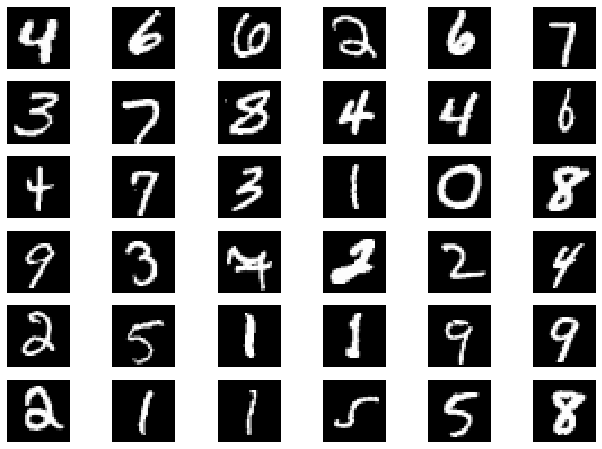

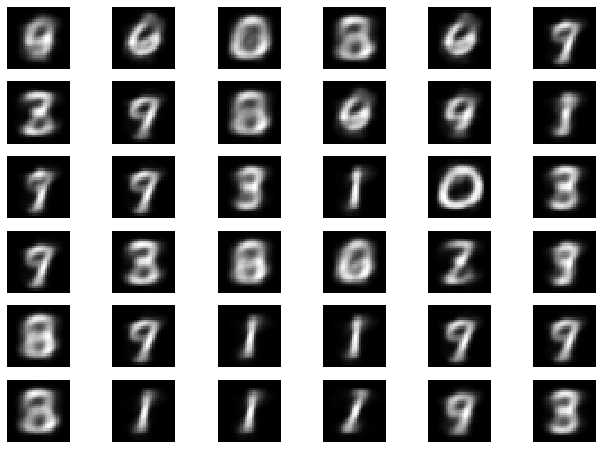

In [293]:
fig1 = "Figs_Raw/Fig1_Sample.png"
fig2 = "Figs_Raw/Fig1_Reconstructed.png"
plot_samples_final(trainX, trainy, W, b, fig1, fig2)

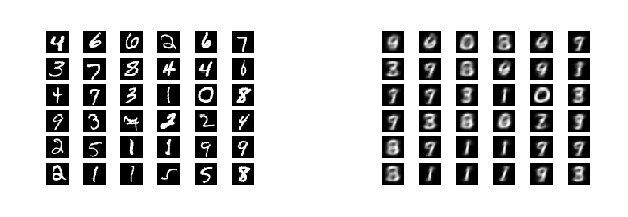

In [294]:
combine_fig(fig1, fig2, "Figs/Fig2.png")

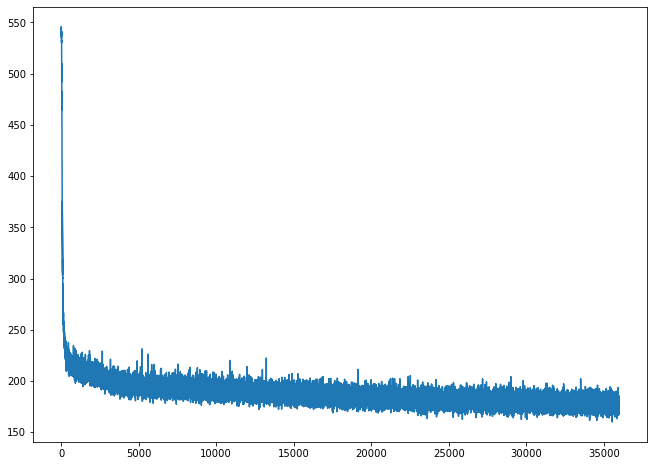

In [158]:
fig, ax = plt.subplots(1,1)
plt.plot(loss)
fig.savefig("Figs/Fig1.png")

### 9.2 Section 2.3 ADAM

In [295]:
filename = "Files/2020_04_24_12_38_14_Model_v1.1_parameter.txt"
para = get_para(filename)
doc = para['doc']
W = para['W']
b = para['b']
loss = para['loss']

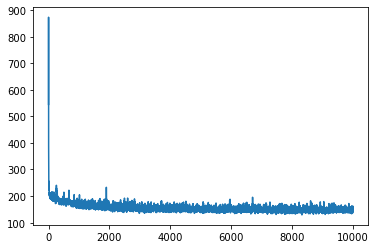

In [168]:
fig, ax = plt.subplots(1,1)
plt.plot(loss)
fig.savefig("Figs/Fig3.png")

In [296]:
filename = "Files/2020_04_24_22_18_49_Model_v1.1_parameter.txt"
para = get_para(filename)
doc = para['doc']
W = para['W']
b = para['b']
loss = para['loss']

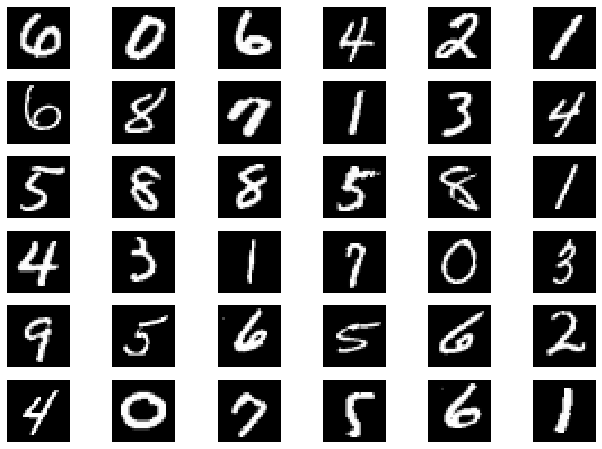

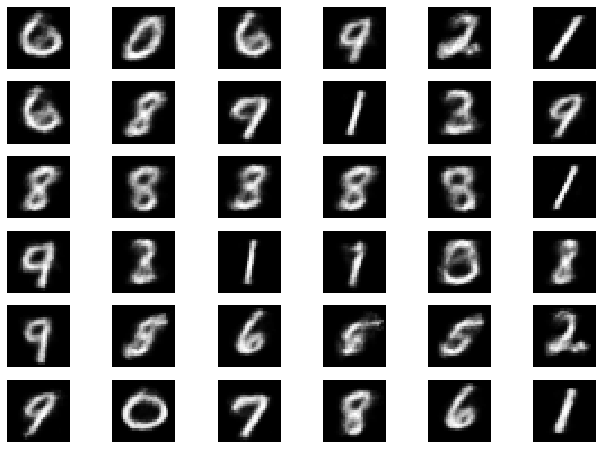

In [297]:
fig1 = "Figs_Raw/Fig4_Sample.png"
fig2 = "Figs_Raw/Reconstructed.png"
plot_samples_final(trainX, trainy, W, b, fig1, fig2)

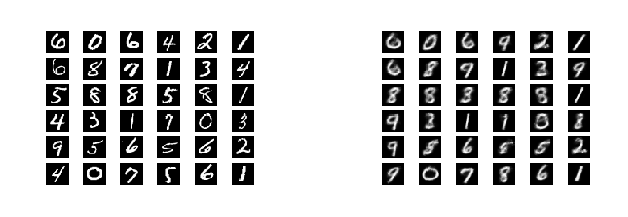

In [298]:
combine_fig(fig1, fig2, "Figs/Fig4.png")

### 9.3 Section 2.4 Profiling

In [179]:
profile_filename = "Files/2020_04_24_11_18_59_Model_v1.1_profiling_v1.prof"
p = pstats.Stats(profile_filename)
p.sort_stats('time', 'cumulative').print_stats(5)
pass

Fri Apr 24 15:20:34 2020    2020_04_24_11_18_59_Model_v1.1_profiling_v1.prof

         466012 function calls (464012 primitive calls) in 93.961 seconds

   Ordered by: internal time, cumulative time
   List reduced from 74 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      100   80.268    0.803   81.196    0.812 <ipython-input-11-993a77bdd1ab>:1(grad)
        1    4.939    4.939   93.957   93.957 <ipython-input-17-e38d5ace111a>:1(train_ADAM)
    10000    2.440    0.000    2.655    0.000 <ipython-input-8-0aeb9911c8e9>:1(encoder_forward)
    10000    2.076    0.000    2.581    0.000 <ipython-input-10-317b689125af>:1(decoder_forward)
      100    1.382    0.014    1.927    0.019 <ipython-input-7-fd1817a619e0>:1(total_loss)




### 9.4 Section 3.1 MNIST Dataset

In [308]:
filename = "Files/2020_04_30_Final_Model_dz3_100k_parameter.txt"
para = get_para(filename)
doc = para['doc']
W = para['W']
b = para['b']
loss = para['loss']

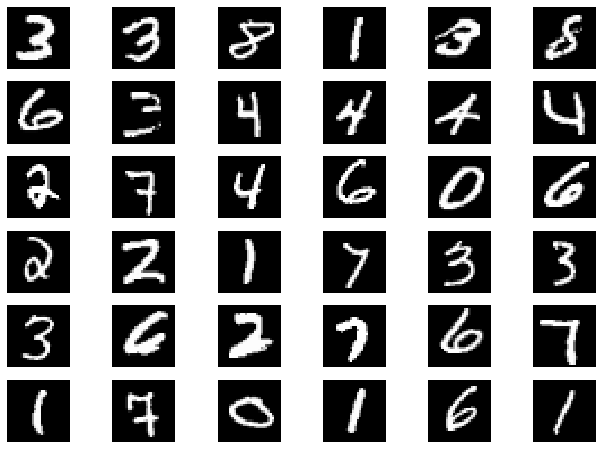

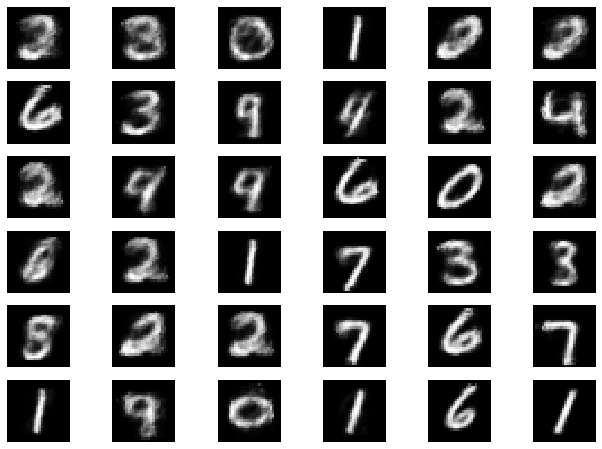

In [309]:
fig1 = "Figs_Raw/Fig9_Sample.png"
fig2 = "Figs_Raw/Fig9_Reconstructed.png"
plot_samples_final(trainX, trainy, W, b, fig1, fig2)

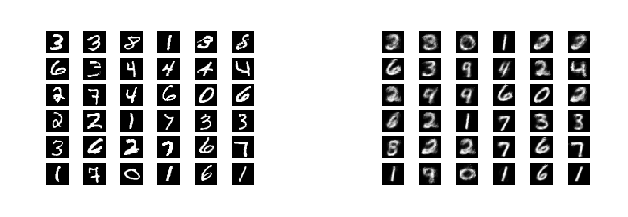

In [311]:
combine_fig(fig1, fig2, "Figs/Fig9.png")

In [302]:
filename = "Files/2020_04_30_Final_Model_dz5_100k_parameter.txt"
para = get_para(filename)
doc = para['doc']
W = para['W']
b = para['b']
loss = para['loss']

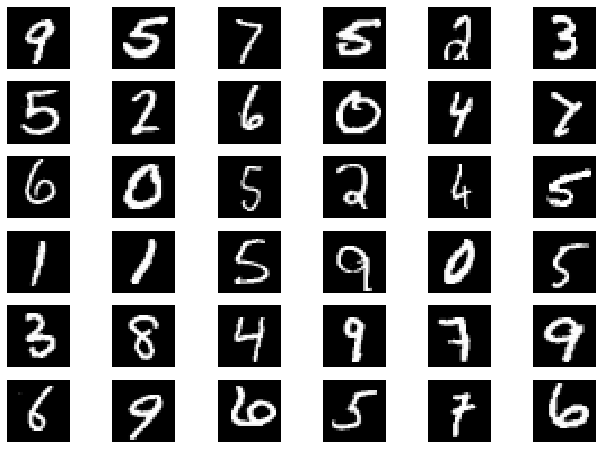

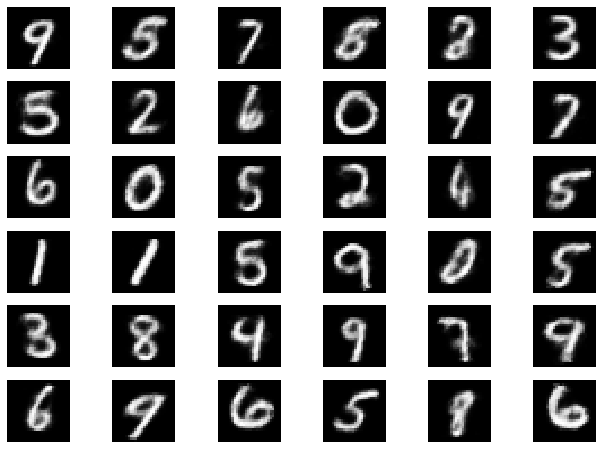

In [303]:
fig1 = "Figs_Raw/Fig10_Sample.png"
fig2 = "Figs_Raw/Fig10_Reconstructed.png"
plot_samples_final(trainX, trainy, W, b, fig1, fig2)

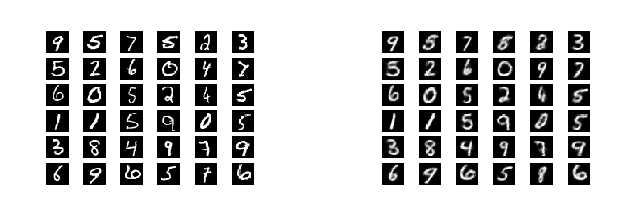

In [304]:
combine_fig(fig1, fig2, "Figs/Fig10.png")

In [305]:
filename = "Files/2020_04_30_Final_Model_dz10_100k_parameter.txt"
para = get_para(filename)
doc = para['doc']
W = para['W']
b = para['b']
loss = para['loss']

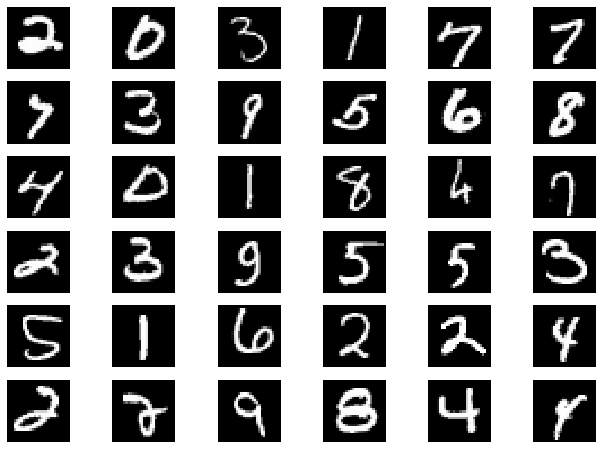

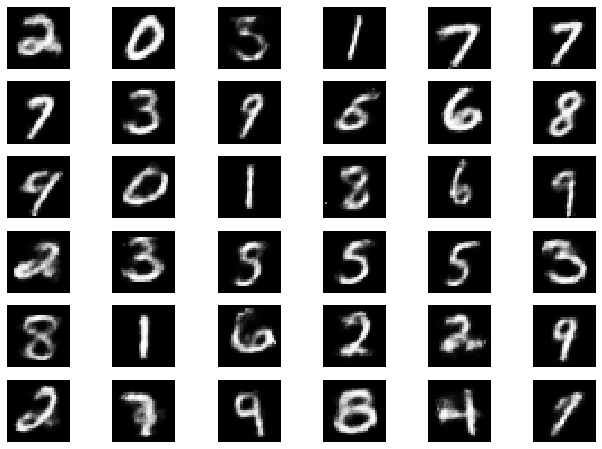

In [306]:
fig1 = "Figs_Raw/Fig11_Sample.png"
fig2 = "Figs_Raw/Fig11_Reconstructed.png"
plot_samples_final(trainX, trainy, W, b, fig1, fig2)

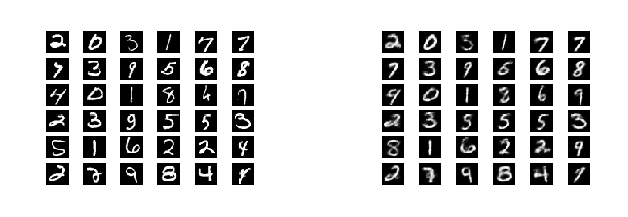

In [307]:
combine_fig(fig1, fig2, "Figs/Fig11.png")

### 9.5 Section 3.2 Caltech Dataset

In [10]:
filename = "Files/2020_04_30_22_41_05_Model_v1.3_parameter_Caltech.txt"
para = get_para(filename)
doc = para['doc']
W = para['W']
b = para['b']
loss = para['loss']

In [97]:
def plot_samples_caltech(trainX, trainy, W, b, fig1, fig2, std_const = 255):
    """
    Randomly sample 9 figures from training data, reconstruct based on 
    user specified model parameters and plot for comparison.
    
    Input parameters：
    ----------
    trainX: array_like
            Training dataset inputs.
            Dimension: number of sample by dim1 by dim2 ...
    trainy: array_like
            Training dataset labels. 
            This variable is not currently used in the function. For further developments.
    W: list
            List of model weights parameters, same format as train_AEVB function output variable W.
    b: list
            List of model bias parameters, same format as train_AEVB function output variable b.
    std_const: integer, optional
            Normlizing constant to reconstruct data.
            Currently default at 255 which is usually used for black and white image data.            
    
    Output:
    ----------
    9 random sampled figures from training data and the model-reconstructed ones for comparison
    """

    dx = trainX.shape[1]
    M = 36
    L = 1
    dz, dm = W[1].shape[0], W[1].shape[1]
    Xdim1 = Xdim2 = int(np.sqrt(dx))
    Spec = [1, M, L, 255, dx, dm, dz, 0.005, 0]
    n = int(np.sqrt(M))
    
    batchX, batchy = get_Batch_nb(M, trainX, trainy)
    X = batchX.reshape(M, dx) / std_const
    eps = np.zeros((L, dz))
    
    y, q_h1, p_h2, q_mu, q_s2, z, loss = batch_forward_vec_nb2(Spec, X, W, b, eps)
    
    fig, ax = plt.subplots(M)
    #fig.suptitle('Sample Images')
    
    for i in range(M):
        # define subplot
        plt.subplot(n,n,i+1)
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(batchX[i].reshape(Xdim1,Xdim2), cmap=plt.get_cmap('gray'))
    # show the figure
    plt.axis('off')
    plt.show()
    fig.savefig(fig1)

    fig, ax = plt.subplots(M)
    #fig.suptitle('Reconstructed Images')
    
    for i in range(M):
        # define subplot
        plt.subplot(n,n,i+1)
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(y[i,L-1,].reshape(Xdim1, Xdim2) * std_const, cmap=plt.get_cmap('gray'))
    # show the figure

    plt.show()
    fig.savefig(fig2)

In [15]:
from scipy.io import loadmat
caltech = loadmat('Files/caltech101_silhouettes_16.mat')
calX = caltech['X']
caly = caltech['Y'].reshape(-1,1)

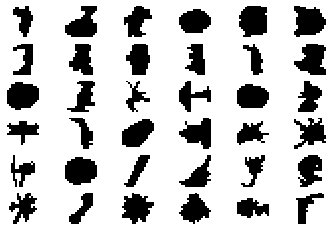

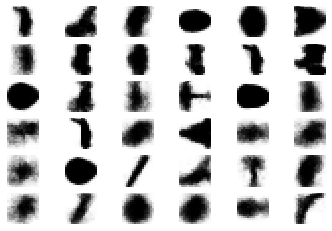

In [98]:
fig1 = "Figs_Raw/Fig12_Sample.png"
fig2 = "Figs_Raw/Fig12_Reconstructed.png"
plot_samples_caltech(calX, caly, W, b, fig1, fig2, std_const = 1)

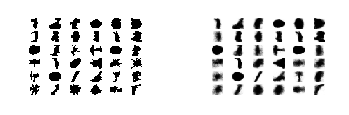

In [101]:
combine_fig(fig1, fig2, "Figs/Fig12.png")